# v7 Leveraging methylation information to predict TF binding

*   this JNB plots the results of bedtools intersections and python AUROC calculations:
    * many bash scripts to bedtools-intersect 4 data types <br>
        <code>git clone https://github.com/dcolinmorgan/mili_benchmark ~/src/mili_benchmark
       bash camb_motif_pipeline_gamma.sh -b0 -c'A549 K562 GM12878 SKNSH HepG2 HeLa' -o'outdirXX'</code>
        
    * Roughly, this carries out the following operations: <br>

        1. Separate hg38 meme file into individual motif files (730)
        1. Run FIMO with threshold=0.00001 and auto-background
        1. Convert fimo-output to bedfile output
        1. For every motif bedfile & for every cell line score motif locations 1 where ∩Ch observed, otherwise 0 within following operations: <br>
            1. nonCG motif + ∩Ch
                1. Input: Intersect motif locations devoid of CG to ChIP
            1. CG motif + ∩Ch 
                1.Input: Intersect CG containing motif to ChIP
                1. Parameters: motif length, CG count per motif
                1. Output: Figure SM1-SM3, Confirm baseline motif AUROC [23]
            1. CG motif + ∩WB +∩Ch
                1. Input: Intersect full motif with WGBS methyl-data
                1. Parameter: sequence read depth
                1. Output: Figure S4
            1. CG motif + ∩WB +∩M+∩Ch
                1. Input: Intersect full motif with methyl array data
                1. Parameter: add +/- 0-10kb buffer sizes (Figure SM4)
                1. Output: Main analysis (Figures 2-5, S1-S3)
        <br><br>
    2.  Output files are variously stored in the following directories: <br>
        <code>main='udd/redmo'
        arxiv0='../../proj/remprs/rempr00/' ## unable to access from JNB
        arxiv1='../../d/tmp/redmo/' </code> <br> <br>
    3. These are read in and AUROC values are calculated via many python functions (functions and altered copies due to varying bash output/input): <br>
        <code>python mili_benchmark/run_predScore.py -i outdirXX -o outdirXX/test</code> <br><br>


* __Supplemental__
    * [Figure SM1](#Figure-SM1)
    * [Figure SM2](#Figure-SM2)
    * [Figure SM3](#Figure-SM3)
    * [Figure SM4](#Figure-SM4)
* __Main Text__
    * [Figure 1](#Figure-1)
    * [Figure 2 and S1](#Figure-2-and-S1)
    * [Figure 3 and S2](#Figure-3-and-S2)
    * [Figure 4 and S3](#Figure-4-and-S3)
    * [Figure 5A](#Figure-5A)
    * [Figure 5B](#Figure-5B)
    * [Figure S4](#Figure-S4)

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import transforms
import glob
from pathlib import Path
from scipy import stats
from matplotlib import colors
from matplotlib.colors import DivergingNorm
import plotly.express as px

import seaborn as sns
import scipy as sp
from sklearn import metrics
from collections import Counter
os.getcwd()
## navigate to /udd/redmo
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
os.chdir('..')

# os.chdir('../proj/regeps/regep00/')#studies/LTRC/data/epigenetic/methylation/TopMed/data/tests/rejpz/LEVEL4')
# os.chdir("../../../../proj/regeps/regep00/studies/COPDGene/analyses/rebdh/ltrc/")

os.getcwd()

'/udd/redmo'

In [13]:
main=''
arxiv0='../../proj/remprs/rempr00/' ## unable to access from JNB
arxiv1='../../d/tmp/redmo/'

# Figure SM1

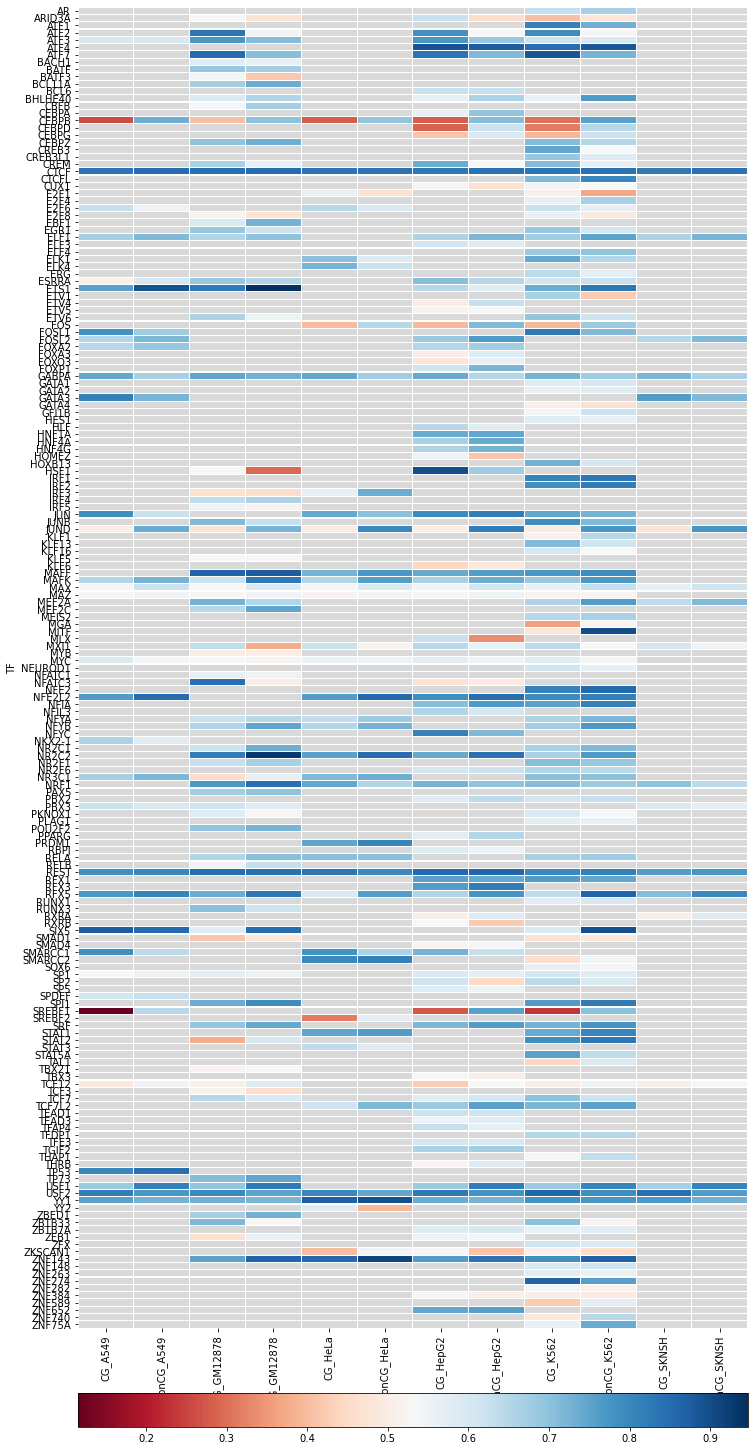

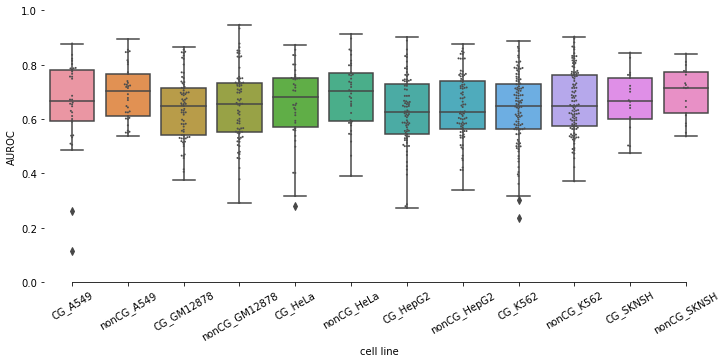

In [5]:
indir="../../d/tmp/redmo/camb_motif/camb_PRE_overall.txt"
outdir="../../d/tmp/redmo/chan_review/"
Path(outdir).mkdir(parents=True, exist_ok=True)

agg_meth='mean'
measure='auroc'
region='all'
depth='all'

aurocs=pd.read_table(indir,sep=',',names=['cell','TF','CG','nonCG'])
aurocs=aurocs[aurocs.cell!='0']


heat=aurocs.pivot_table(index=['TF'], columns='cell')

heat=heat.dropna(axis=1, how='all')

heat=pd.DataFrame(heat.to_records())

heat.columns=['TF','CG_A549','CG_GM12878','CG_HeLa','CG_HepG2','CG_K562','CG_SKNSH',
             'nonCG_A549','nonCG_GM12878','nonCG_HeLa','nonCG_HepG2','nonCG_K562','nonCG_SKNSH']


heat=heat[['TF','CG_A549','nonCG_A549',#'A549_diff',
           'CG_GM12878','nonCG_GM12878',#'GM12878_diff',
           'CG_HeLa','nonCG_HeLa',#'HeLa_diff',
           'CG_HepG2','nonCG_HepG2',#'HepG2_diff',
           'CG_K562','nonCG_K562',#'K562_diff',
           'CG_SKNSH','nonCG_SKNSH'#'SKNSH_diff'
           ]]
heat55=heat
heat=heat.set_index('TF')

plt.figure(figsize=(12, 30))

rdgn = plt.get_cmap("RdBu")
rdgn.set_bad(color='black', alpha=0.15)

ax = sns.heatmap(heat,linewidth=.1,cmap=rdgn, cbar=False,mask=heat.isnull(),yticklabels=True)#cbar_ax=cbar_ax,cbar_kws={"orientation": "horizontal"})
mappable = ax.get_children()[0]
plt.colorbar(mappable, ax = [ax],orientation = 'horizontal',pad=.04) #.02 with 12x60, .03 for 12x40


plt.savefig(outdir+"sthlm_"+measure+"_heat.png",dpi=300,bbox_inches = "tight")
plt.show


box=heat55
# box.columns=['TF','A549','GM12878','H1','HeLa','HepG2','K562','SKNSH']
meltbox=pd.melt(box,id_vars=['TF'])
# del box.TF
if measure=='auroc':
    meltbox.columns=['TF','cell line','AUROC']
    plt.figure(figsize=(12, 5))
    plt.xticks(rotation=30)
    g=sns.boxplot(x='cell line',y='AUROC', data=meltbox)
    g=sns.swarmplot(x='cell line',y='AUROC', data=meltbox,
                  size=2, color=".3", linewidth=0)

    g.set(ylim=(0, 1))
plt.savefig(outdir+"camb_heat_CG-non.png",dpi=300,bbox_inches = "tight")
# meltbox.to_csv(outdir+measure+"meltbox.txt")


sns.despine(trim=True, left=True)
plt.show()


t0a, p0a = stats.ttest_ind(box['CG_A549'].dropna(),box['nonCG_A549'].dropna())
t1a, p1a = stats.ttest_ind(box['CG_GM12878'].dropna(),box['nonCG_GM12878'].dropna())
t2a, p2a = stats.ttest_ind(box['CG_HeLa'].dropna(),box['nonCG_HeLa'].dropna())
t3a, p3a = stats.ttest_ind(box['CG_HepG2'].dropna(),box['nonCG_HepG2'].dropna())
t4a, p4a = stats.ttest_ind(box['CG_K562'].dropna(),box['nonCG_K562'].dropna())
t5a, p5a = stats.ttest_ind(box['CG_SKNSH'].dropna(),box['nonCG_SKNSH'].dropna())


# initialise data of lists. 
ttest = {'CG-nonCG ttest':[t0a,t1a,t2a,t3a,t4a,t5a], 'CG-non pvalue':[p0a,p1a,p2a,p3a,p4a,p5a],}# 'Me ttest':[t0b,t1b,t2b,t3b,t4b],'Me pvalue':[p0b,p1b,p2b,p3b,p4b]} 

# Creates pandas DataFrame. 
df_ttest = pd.DataFrame(ttest, index =['A549','GM12878', 'HeLa', 'HepG2', 'K562','SKNSH']) 

df_ttest.to_csv(outdir+"/camb_ttest.txt")
meltbox.to_csv(outdir+"/camb_meltbox.txt",sep='\t')

[(0.0, 1.0)]

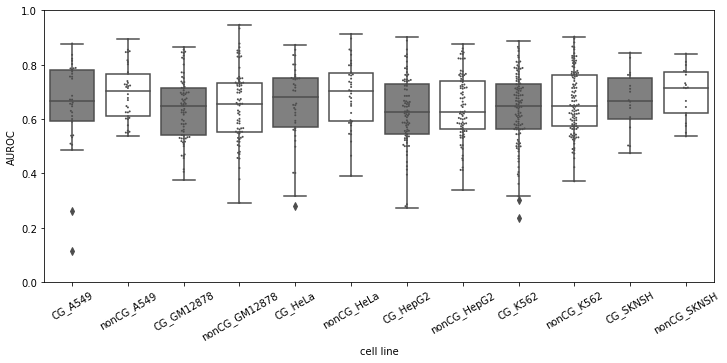

In [6]:
meltbox.columns=['TF','cell line','AUROC']
plt.figure(figsize=(12, 5))
plt.xticks(rotation=30)
g=sns.boxplot(x='cell line',y='AUROC', data=meltbox,palette=['grey','white'])
g=sns.swarmplot(x='cell line',y='AUROC', data=meltbox,
              size=2, color=".3", linewidth=0)

g.set(ylim=(0, 1))

# Figure SM2

In [19]:
!be rempr00

chanjnb:rempr00 12% chanjnb:rempr00 12% 

In [22]:
# d1=pd.read_table('data/MotifPipeline/compare/sthlm_motif_0_QCbeta/red/test/all/all/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,9,10,11,12,13,14,15,16,17],names=['cell','TF','size','counts','length','mean_dist_array','mean_dist_wg','mean_dist_pwm','hits_array','hits_wg','hits_pwm'])
# d1=d1[d1.cell!='0']

d2=pd.read_table('data/MotifPipeline/compare/sthlm_motif_5_QCbeta/red/test/all/all/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,9,10,11,12,13,14,15,16,17],names=['cell','TF','size','counts','length','mean_dist_array','mean_dist_wg','mean_dist_pwm','hits_array','hits_wg','hits_pwm'])
d2=d2[d2.cell!='0']

d3=pd.read_table('data/MotifPipeline/compare/sthlm_motif_10_QCbeta/red/test/all/all/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,9,10,11,12,13,14,15,16,17],names=['cell','TF','size','counts','length','mean_dist_array','mean_dist_wg','mean_dist_pwm','hits_array','hits_wg','hits_pwm'])
d3=d3[d3.cell!='0']

d4=pd.read_table('data/MotifPipeline/compare/sthlm_motif_20_QCbeta/red/test/all/all/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,9,10,11,12,13,14,15,16,17],names=['cell','TF','size','counts','length','mean_dist_array','mean_dist_wg','mean_dist_pwm','hits_array','hits_wg','hits_pwm'])
d4=d4[d4.cell!='0']

d5=pd.read_table('data/MotifPipeline/compare/sthlm_motif_50_QCbeta/red/test/all/all/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,9,10,11,12,13,14,15,16,17],names=['cell','TF','size','counts','length','mean_dist_array','mean_dist_wg','mean_dist_pwm','hits_array','hits_wg','hits_pwm'])
d5=d5[d5.cell!='0']

d6=pd.read_table('data/MotifPipeline/compare/sthlm_motif_100_QCbeta/red/test/all/all/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,9,10,11,12,13,14,15,16,17],names=['cell','TF','size','counts','length','mean_dist_array','mean_dist_wg','mean_dist_pwm','hits_array','hits_wg','hits_pwm'])
d6=d6[d6.cell!='0']  

d7=pd.read_table('data/MotifPipeline/compare/sthlm_motif_250_QCbeta/red/test/all/all/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,9,10,11,12,13,14,15,16,17],names=['cell','TF','size','counts','length','mean_dist_array','mean_dist_wg','mean_dist_pwm','hits_array','hits_wg','hits_pwm'])
d7=d7[d7.cell!='0']  

d8=pd.read_table('data/MotifPipeline/compare/sthlm_motif_500_QCbeta/red/test/all/all/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,9,10,11,12,13,14,15,16,17],names=['cell','TF','size','counts','length','mean_dist_array','mean_dist_wg','mean_dist_pwm','hits_array','hits_wg','hits_pwm'])
d8=d8[d8.cell!='0'] 

d9=pd.read_table(arxiv0+'data/MotifPipeline/compare/sthlm_motif_1000_QCbeta/red/test/all/all/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,9,10,11,12,13,14,15,16,17],names=['cell','TF','size','counts','length','mean_dist_array','mean_dist_wg','mean_dist_pwm','hits_array','hits_wg','hits_pwm'])
d9=d9[d9.cell!='0']  

d10=pd.read_table(arxiv0+'data/MotifPipeline/sthlm_motif_5000_QCbeta/red/test/all/all/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,9,10,11,12,13,14,15,16,17],names=['cell','TF','size','counts','length','mean_dist_array','mean_dist_wg','mean_dist_pwm','hits_array','hits_wg','hits_pwm'])
d10=d10[d10.cell!='0']  

d11=pd.read_table(arxiv0+'data/MotifPipeline/sthlm_motif_10000_QCbeta/red/test/all/all/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,9,10,11,12,13,14,15,16,17],names=['cell','TF','size','counts','length','mean_dist_array','mean_dist_wg','mean_dist_pwm','hits_array','hits_wg','hits_pwm'])
d11=d11[d11.cell!='0']  

d12=pd.read_table(arxiv0+'data/MotifPipeline/sthlm_motif_50000_QCbeta/red/test/all/all/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,9,10,11,12,13,14,15,16,17],names=['cell','TF','size','counts','length','mean_dist_array','mean_dist_wg','mean_dist_pwm','hits_array','hits_wg','hits_pwm'])
d12=d12[d12.cell!='0']  

# plt.scatter(d1.mean_dist_array,d1.mean_dist_wg,label='orig motif',alpha=.5)
plt.scatter(d2.mean_dist_array,d2.mean_dist_wg,label='+5bp',alpha=.5)
plt.scatter(d3.mean_dist_array,d3.mean_dist_wg,label='+10bp',alpha=.5)
plt.scatter(d4.mean_dist_array,d4.mean_dist_wg,label='+20bp',alpha=.5)
plt.scatter(d5.mean_dist_array,d5.mean_dist_wg,label='+50bp',alpha=.5)
plt.scatter(d6.mean_dist_array,d6.mean_dist_wg,label='+100bp',alpha=.5)
plt.scatter(d7.mean_dist_array,d7.mean_dist_wg,label='+250bp',alpha=.5)
plt.scatter(d8.mean_dist_array,d8.mean_dist_wg,label='+500bp',alpha=.5)
plt.scatter(d9.mean_dist_array,d9.mean_dist_wg,label='+1000bp',alpha=.5)
plt.scatter(d10.mean_dist_array,d10.mean_dist_wg,label='+5000bp',alpha=.5)
plt.scatter(d11.mean_dist_array,d11.mean_dist_wg,label='+10000bp',alpha=.5)
plt.scatter(d12.mean_dist_array,d12.mean_dist_wg,label='+5000bp',alpha=.5)

# plt.xlim(0, 1)
# plt.ylim(0, 1)
plt.legend(loc="best")#,bbox_to_anchor=(1,1))
plt.xlabel('mean dist wgbs')
plt.ylabel('mean dist array')
plt.title('mean pairwise distance across all TF/cell combs')
outdir='mili_benchmark/figures/'
plt.savefig(outdir+"SM2.png")

FileNotFoundError: [Errno 2] No such file or directory: '../../d/tmp/redmo/data/subPipeTest/0/test/camb_PRE_overall.txt'

# Figure SM3

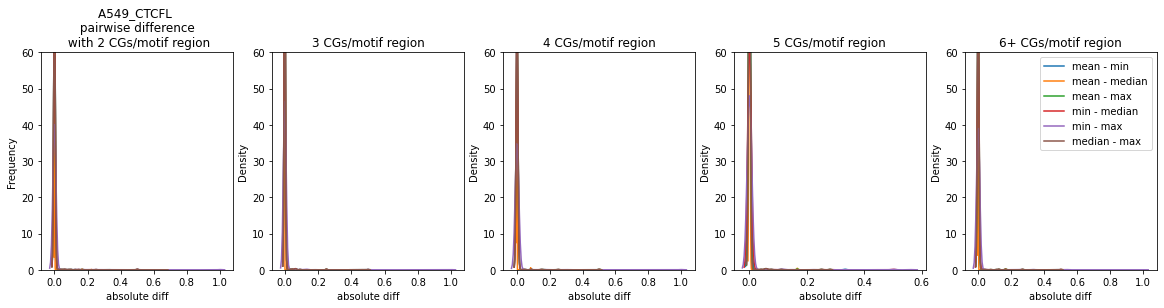

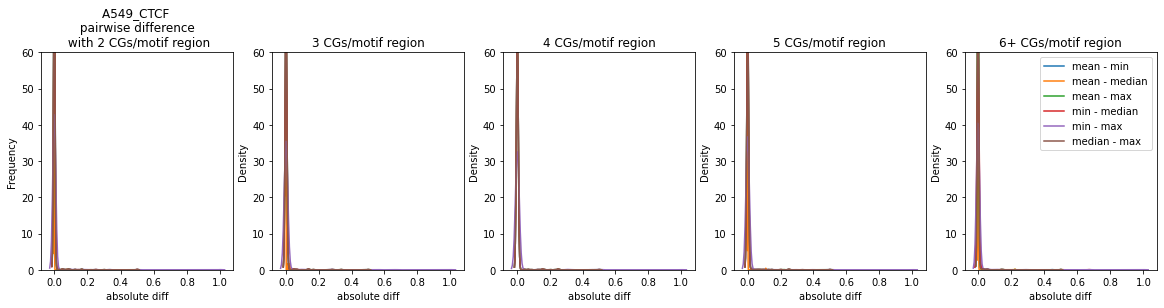

In [23]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
# import matplotlib.backends.backend_pdf
table=[]
TF='CTCF'
cell='A549'
traces= glob.glob(arxiv1+'data/MotifPipeline/sthlm_motif_0_QCbeta/*')

# pdf = matplotlib.backends.backend_pdf.PdfPages("output.pdf")
indices = [i for i, s in enumerate(traces) if cell+'_'+TF in s]

for jac,zzzz in enumerate(indices):
    data=pd.read_csv(traces[zzzz],sep='\t',usecols=[0,1,2,3,4,8,9,10,11,12,16],names=["chr", "start", "end",'weight','CG','hits',"wgbs",'array','body','TSS','ChIPTF'])

    table2=[]
    tbl=[]
    tmpTBL2=[]
    tmpTBL=[]

    # Refit data to 0-1    
    data.ChIPTF=data.ChIPTF.replace('.','0')
    data.ChIPTF[data.ChIPTF!=0]=1
    data=data[(data.ChIPTF==0)|(data.ChIPTF==1)]
    data.ChIPTF=pd.to_numeric(data.ChIPTF)
    
    data['wgbs']=1-(data['wgbs']/100)
    data['array'] = np.where(data['weight'] == data['array'], data['array'],1-data['array'])

    df3=data.groupby([data.chr,data.start,data.end,data.weight,data.wgbs]).size().reset_index(name='counts')

    df=data.groupby([data.chr,data.start,data.end]).size().reset_index(name='counts')
    data1 = data.groupby([data.chr,data.start,data.end]).agg({'weight':'mean',"wgbs":'mean',"array":'mean'})
    data1=data1.merge(df,on=['chr','start','end'])
    data1=data1.drop_duplicates()

    data2 = data.groupby([data.chr,data.start,data.end]).agg({'weight':'min',"wgbs":'min',"array":'min'})
    data2=data2.merge(df,on=['chr','start','end'])
    data2=data2.drop_duplicates()
    data3 = data.groupby([data.chr,data.start,data.end]).agg({'weight':'median',"wgbs":'median',"array":'median'})
    data3=data3.merge(df,on=['chr','start','end'])
    data3=data3.drop_duplicates()
    data4 = data.groupby([data.chr,data.start,data.end]).agg({'weight':'max',"wgbs":'max',"array":'max'})
    data4=data4.merge(df,on=['chr','start','end'])
    data4=data4.drop_duplicates()

    f= plt.figure(figsize=(20, 4))
    ## Plot all three value distributions fit to same 0-1 scale


    for jj,start in enumerate(data.start):
        zz=data[data['start']==start]
        if zz.count!=1:
            yy=[np.abs(x - y) for i,x in enumerate(zz.wgbs) for j,y in enumerate(zz.wgbs) if i != j]

        table2.append(np.mean(yy))
        tmpTBL2.append(len(zz))#/np.math.factorial(len(yy)))
    WWW=np.max(tmpTBL2)-1

    data1['freq']=pd.DataFrame(tmpTBL2)
    data2['freq']=pd.DataFrame(tmpTBL2)
    data3['freq']=pd.DataFrame(tmpTBL2)
    data4['freq']=pd.DataFrame(tmpTBL2)

    ax1=plt.subplot(1, 5, 1)
    d1=data1[data1.freq==2]
    if d1.empty is False:
        d2=data2[data2.freq==2]
        d3=data3[data3.freq==2]
        d4=data4[data4.freq==2]
        
        try:
            g=sns.distplot((d1['wgbs']-d2['wgbs']).abs(),kde=True,hist=False,rug=False,label='mean - min')
        except RuntimeError:
            pass
        try:
            g=sns.distplot((d1['wgbs']-d3['wgbs']).abs(),kde=True,hist=False,rug=False,label='mean - median')
        except RuntimeError:
            pass
        try:
            g=sns.distplot((d1['wgbs']-d4['wgbs']).abs(),kde=True,hist=False,rug=False,label='mean - max')
        except RuntimeError:
            pass
        try:
            g=sns.distplot((d2['wgbs']-d3['wgbs']).abs(),kde=True,hist=False,rug=False,label='min - median')
        except RuntimeError:
            pass
        try:
            g=sns.distplot((d2['wgbs']-d4['wgbs']).abs(),kde=True,hist=False,rug=False,label='min - max')
        except RuntimeError:
            pass
        try:
            g=sns.distplot((d3['wgbs']-d4['wgbs']).abs(),kde=True,hist=False,rug=False,label='median - max')
        except RuntimeError:
            pass
        

    if WWW>2:
        ax2=plt.subplot(1, 5, 2)
        d1=data1[data1.freq==3]
        if d1.empty is False:
            d2=data2[data2.freq==3]
            d3=data3[data3.freq==3]
            d4=data4[data4.freq==3]
            try:
                g=sns.distplot((d1['wgbs']-d2['wgbs']).abs(),kde=True,hist=False,rug=False,label='mean - min')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d1['wgbs']-d3['wgbs']).abs(),kde=True,hist=False,rug=False,label='mean - median')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d1['wgbs']-d4['wgbs']).abs(),kde=True,hist=False,rug=False,label='mean - max')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d2['wgbs']-d3['wgbs']).abs(),kde=True,hist=False,rug=False,label='min - median')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d2['wgbs']-d4['wgbs']).abs(),kde=True,hist=False,rug=False,label='min - max')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d3['wgbs']-d4['wgbs']).abs(),kde=True,hist=False,rug=False,label='median - max')
            except RuntimeError:
                pass



    if WWW>3:
        ax3=plt.subplot(1, 5, 3)
        d1=data1[data1.freq==4]
        if d1.empty is False:
            d2=data2[data2.freq==4]
            d3=data3[data3.freq==4]
            d4=data4[data4.freq==4]
            try:
                g=sns.distplot((d1['wgbs']-d2['wgbs']).abs(),kde=True,hist=False,rug=False,label='mean - min')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d1['wgbs']-d3['wgbs']).abs(),kde=True,hist=False,rug=False,label='mean - median')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d1['wgbs']-d4['wgbs']).abs(),kde=True,hist=False,rug=False,label='mean - max')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d2['wgbs']-d3['wgbs']).abs(),kde=True,hist=False,rug=False,label='min - median')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d2['wgbs']-d4['wgbs']).abs(),kde=True,hist=False,rug=False,label='min - max')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d3['wgbs']-d4['wgbs']).abs(),kde=True,hist=False,rug=False,label='median - max')
            except RuntimeError:
                pass


            plt.xlabel('absolute diff')
            ax3.set_ylim([0,60])

            plt.title('4 CGs/motif region')
        else:
            pass
    if WWW>4:
        ax4=plt.subplot(1, 5, 4)
        d1=data1[data1.freq==5]
        if d1.empty is False:
            d2=data2[data2.freq==5]
            d3=data3[data3.freq==5]
            d4=data4[data4.freq==5]
            try:
                g=sns.distplot((d1['wgbs']-d2['wgbs']).abs(),kde=True,hist=False,rug=False,label='mean - min')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d1['wgbs']-d3['wgbs']).abs(),kde=True,hist=False,rug=False,label='mean - median')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d1['wgbs']-d4['wgbs']).abs(),kde=True,hist=False,rug=False,label='mean - max')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d2['wgbs']-d3['wgbs']).abs(),kde=True,hist=False,rug=False,label='min - median')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d2['wgbs']-d4['wgbs']).abs(),kde=True,hist=False,rug=False,label='min - max')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d3['wgbs']-d4['wgbs']).abs(),kde=True,hist=False,rug=False,label='median - max')
            except RuntimeError:
                pass

            plt.xlabel('absolute diff')
            ax4.set_ylim([0,60])

            plt.title('5 CGs/motif region')
        else:
            pass
    if WWW>5:
        ax5=plt.subplot(1, 5, 5)
        d1=data1[data1.freq==6]
        if d1.empty is False:
            d2=data2[data2.freq==6]
            d3=data3[data3.freq==6]
            d4=data4[data4.freq==6]
            try:
                g=sns.distplot((d1['wgbs']-d2['wgbs']).abs(),kde=True,hist=False,rug=False,label='mean - min')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d1['wgbs']-d3['wgbs']).abs(),kde=True,hist=False,rug=False,label='mean - median')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d1['wgbs']-d4['wgbs']).abs(),kde=True,hist=False,rug=False,label='mean - max')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d2['wgbs']-d3['wgbs']).abs(),kde=True,hist=False,rug=False,label='min - median')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d2['wgbs']-d4['wgbs']).abs(),kde=True,hist=False,rug=False,label='min - max')
            except RuntimeError:
                pass
            try:
                g=sns.distplot((d3['wgbs']-d4['wgbs']).abs(),kde=True,hist=False,rug=False,label='median - max')
            except RuntimeError:
                pass
            plt.legend(loc='best')
            plt.xlabel('absolute diff')
            ax5.set_ylim([0,60])
            plt.title('6+ CGs/motif region')
        else:
            pass
    outdir='mili_benchmark/figures/'
    plt.savefig(outdir+"A549_CTCFL_SM1.png")
    plt.show()

# Figure SM4

In [28]:
indirs=('../../d/tmp/redmo/data/subPipeTest/*')
# traces = [log for log in glob.glob(indir+'/**') if not os.path.isdir(log)]
#traces=[x[0] for x in os.walk(indirs)]
traces=glob.glob(indirs)
# traces
outdir='../../d/tmp/redmo/data/'
allbox = pd.DataFrame()


indir='../../d/tmp/redmo/data/subPipeTest/**'
traces= glob.glob(indir+'/test/*.txt',recursive = True)

indices = [i for i, s in enumerate(traces) if 'camb_auroc_meltbox' in s]
method='auroc'

for jac in (indices):
    trace=traces[jac]
    if 'pc' in trace:
        buffer=(trace).split('/')[6]

    elif 'd/tmp' in trace:
        buffer=(trace).split('/')[7]

    meltbox=pd.read_csv(trace,sep='\t')
    meltbox['buffer']=buffer
    allbox=pd.concat([allbox,meltbox],axis=0)
allbox['cell_buff']=allbox['data - cell line']+'_'+allbox['buffer'].astype(str)
from pathlib import Path

Path(outdir).mkdir(parents=True, exist_ok=True)



cells=['A549','GM12878', 'HeLa', 'HepG2', 'K562','SKNSH']
tests=['pwm','me','wg']


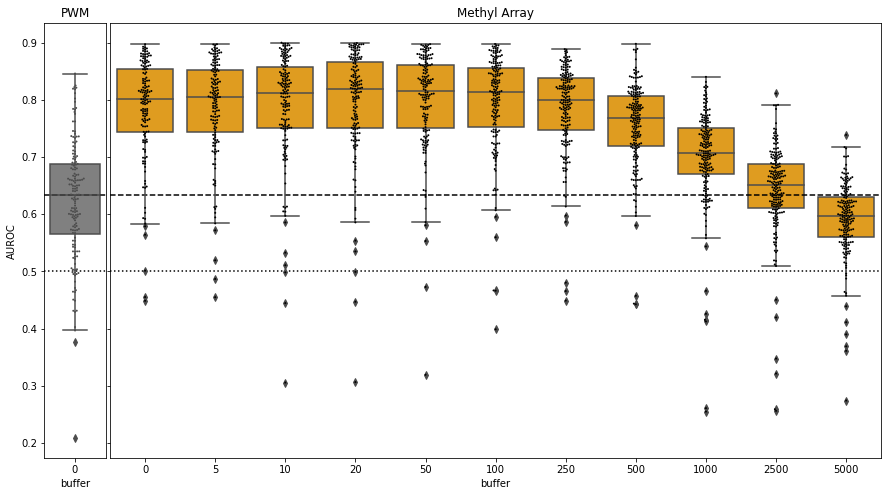

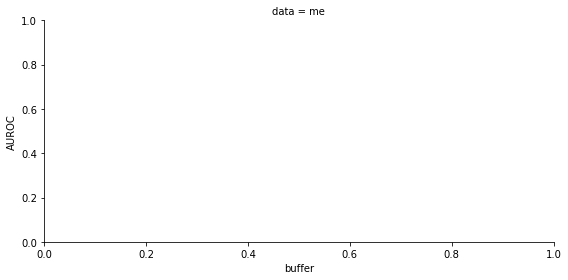

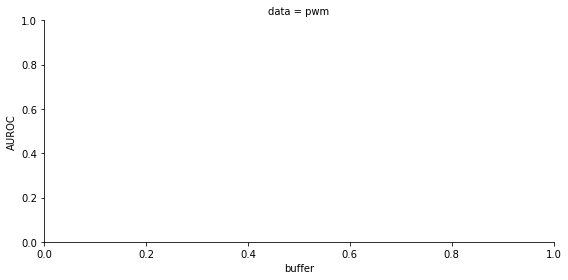

In [29]:
allbox['data']=allbox['data - cell line'].str.split('-').str[0].tolist()

count=allbox.groupby([allbox.TF,allbox.data,allbox.buffer],as_index=False).mean()
count=count[count['AUROC']<.9]
count=count[count['AUROC']>.2]
# count['wAUROC']=count['size']*count['AUROC']
allbox0=count[count['data'].str.contains(pat='pwm')]
med=np.median(allbox0[allbox0['buffer']=='0'].dropna().AUROC)

f,(ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(15, 8),gridspec_kw={'width_ratios':[0.08,1],"wspace":0.01})

g = sns.FacetGrid(count, height=4, aspect=2,row='data',row_order=["me"])
g.map(sns.boxplot, "buffer", "AUROC",ax=ax2,color="orange",order=['0','5','10','20','50','100','250','500','1000','2500','5000'])
g.map(sns.swarmplot, "buffer", "AUROC",size=2,ax=ax2, color=".0", linewidth=0,order=['0','5','10','20','50','100','250','500','1000','2500','5000'])
g.set(ylim=(0, 1))
ax2.axline((0.5, 0.5), slope=0, c="0", ls=":", zorder=1)
ax2.axline((med,med), slope=0, c="0", ls="--", zorder=1)
ax2.label_outer()

g = sns.FacetGrid(count, height=4, aspect=2,row='data',row_order=["pwm"])
g.map(sns.boxplot, "buffer", "AUROC",ax=ax1,order=['0'],color="grey")
g.map(sns.swarmplot, "buffer", "AUROC",size=2,ax=ax1, color=".3", linewidth=0,order=['0'])
g.set(ylim=(0, 1))
ax1.axline((0.5, 0.5), slope=0, c="0", ls=":", zorder=1)
ax1.axline((med,med), slope=0, c="0", ls="--", zorder=1)
# ax.label_outer()

ax1.set_title('PWM')
ax2.set_title('Methyl Array')

plt.savefig(outdir+"SM4B.png",dpi=300,bbox_inches = "tight")


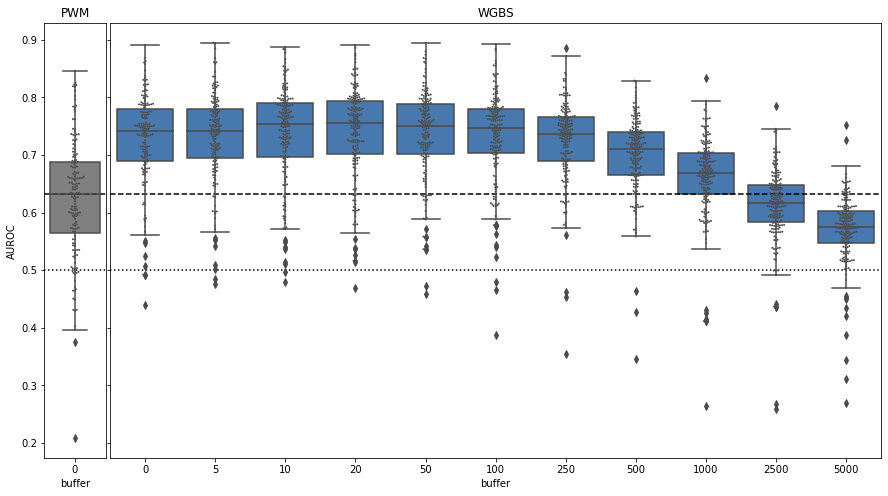

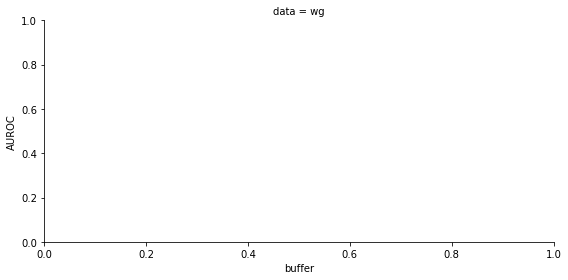

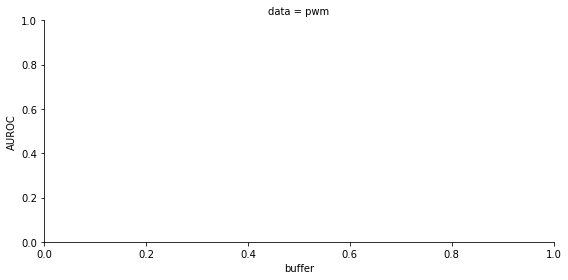

In [30]:
allbox['data']=allbox['data - cell line'].str.split('-').str[0].tolist()

count=allbox.groupby([allbox.TF,allbox.data,allbox.buffer],as_index=False).mean()
count=count[count['AUROC']<.9]
count=count[count['AUROC']>.2]
# count['wAUROC']=count['size']*count['AUROC']
allbox0=count[count['data'].str.contains(pat='pwm')]
med=np.median(allbox0[allbox0['buffer']=='0'].dropna().AUROC)

f,(ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(15, 8),gridspec_kw={'width_ratios':[0.08,1],"wspace":0.01})

g = sns.FacetGrid(count, height=4, aspect=2,row='data',row_order=["wg"])
g.map(sns.boxplot, "buffer", "AUROC",ax=ax2,color=sns.xkcd_rgb["windows blue"],order=['0','5','10','20','50','100','250','500','1000','2500','5000'])
g.map(sns.swarmplot, "buffer", "AUROC",size=2,ax=ax2, color=".3", linewidth=0,order=['0','5','10','20','50','100','250','500','1000','2500','5000'])
g.set(ylim=(0, 1))
ax2.axline((0.5, 0.5), slope=0, c="0", ls=":", zorder=1)
ax2.axline((med,med), slope=0, c="0", ls="--", zorder=1)
ax2.label_outer()

g = sns.FacetGrid(count, height=4, aspect=2,row='data',row_order=["pwm"])
g.map(sns.boxplot, "buffer", "AUROC",ax=ax1,order=['0'],color="grey")
g.map(sns.swarmplot, "buffer", "AUROC",size=2,ax=ax1, color=".3", linewidth=0,order=['0'])
g.set(ylim=(0, 1))
ax1.axline((0.5, 0.5), slope=0, c="0", ls=":", zorder=1)
ax1.axline((med,med), slope=0, c="0", ls="--", zorder=1)

ax1.set_title('PWM')
ax2.set_title('WGBS')

plt.savefig(outdir+"SM4A.png",dpi=300,bbox_inches = "tight")


# Figure 1

In [31]:

# trace='data/MotifPipeline/compare/sthlm_motif_0_QCbeta/A549_CTCF'
trace=main+'data/MotifPipeline/compare/sthlm_motif_0_QCbeta/A549_CTCF'
data=pd.read_csv(trace,sep='\t',usecols=[0,1,2,3,4,5,6,7,8,9,10,11,15,16],names=["chr", "start", "end",'weight','pval','chr1','st1','end1',"hits1",'W1','array','region','ChIPTF','gene'])
Col1=os.path.basename(trace).split('_')[0] #cell
Col2=os.path.basename(trace).split('_')[1] #TF
data=data.fillna(0)
data.ChIPTF=data.ChIPTF.replace('.',0)
data.ChIPTF[(data.ChIPTF==Col2)]=1
data=data[(data.ChIPTF==0)|(data.ChIPTF==1)]
data.ChIPTF=pd.to_numeric(data.ChIPTF)
data.weight=(data.weight-data.weight.min())/(data.weight.max()-data.weight.min())

# #     data=data[data.ChIPTF!='.']

data['wgbs']=data.W1/100
data.wgbs=1-data.wgbs
data.array=1-data.array
# data['st1']=data['st1']+5
# data['end1']=data['end1']-5
chr=10
data=data[data['chr']=='chr'+str(chr)]
data=data[(data['start']>400000)&(data['end']<4500000)]
# data


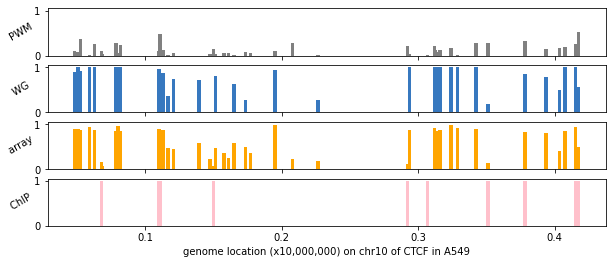

In [32]:
cdict={'GM12878':'red','K-562':'blue','A-549':'green',
       'Hep-G2':'orange','HeLa-S3':'yellow','SK-N-SH':'pink'}
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True, sharey=True,figsize=(10,4))
x=(data.start)/10000000

binwidth = 0.0025

l1=ax1.bar(x,data.weight, width=binwidth,label='PWM',color='grey')
l2=ax2.bar(x,1-data.wgbs, width=binwidth,label='WG',color=sns.xkcd_rgb["windows blue"])
l3=ax3.bar(x,1-data.array, width=binwidth,label='array',color='orange')
l4=ax4.bar(x,data.ChIPTF, width=binwidth,label='ChIP',color='pink')
plt.grid(False)

plt.rcParams.update({'font.size': 30})
h=ax1.set_ylabel('PWM     ')
h.set_rotation(30)
h=ax2.set_ylabel('WG     ')
h.set_rotation(30)
h=ax3.set_ylabel('array     ')
h.set_rotation(30)
h=ax4.set_ylabel('ChIP     ')
h.set_rotation(30)
ax4.set_xlabel('genome location (x10,000,000) on chr'+str(chr)+" of CTCF in A549")
outdir='mili_benchmark/figures'
plt.savefig(outdir+'/'+Col1+'_'+Col2+'_chr'+str(chr)+".png",dpi=300,bbox_inches = "tight")

#     axs.legend(ncol=3,loc=8)

# Figure 2 and S1

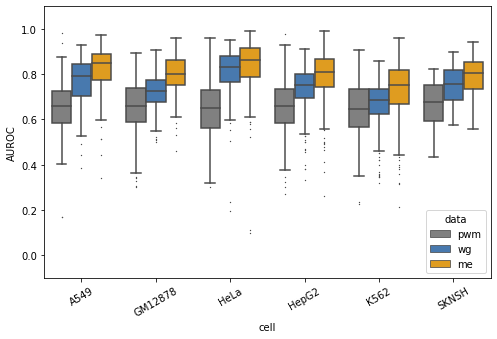

<Figure size 432x288 with 0 Axes>

In [40]:
allbox = pd.DataFrame()
traces= glob.glob('data/MotifPipeline/compare/sthlm_motif_0_QC_beta_red/test/**/all/*.txt',recursive = True)
indices = [i for i, s in enumerate(traces) if 'sthlm_auroc_meltbox' in s]
method='AUROC'

for jac in (indices):
    trace=traces[jac]
    buffer=(trace).split('/')[3]
    buffer=(buffer).split('_')[2]
    region=(trace).split('/')[5]
    depth=(trace).split('/')[6]
    meltbox=pd.read_csv(trace,sep='\t')
    meltbox['buffer']=buffer
    meltbox['region']=region
    meltbox['depth']=depth
    allbox=pd.concat([allbox,meltbox],axis=0)
allbox['cell_buff']=allbox['data - cell line']+'_'+allbox['buffer'].astype(str)
allbox['depth']=allbox['depth'].replace('all',0)
plt.figure(figsize=(8, 5))
plt.xticks(rotation=30)
allbox['data']=allbox['data - cell line'].str.split('-').str[0].tolist()
type=pd.unique(allbox['data'])
allbox['cell']=allbox['data - cell line'].str.split('-').str[1].tolist()
cells=pd.unique(allbox['cell'])
allbox['depth']=allbox.depth.astype(int)
allbox2=allbox.sort_values('cell', axis=0)

aa=allbox2[allbox2['data']=='pwm']
bb=allbox2[allbox2['data']=='wg']
cc=allbox2[allbox2['data']=='me']
allbox2=pd.concat([aa,bb,cc])
g=sns.boxplot(x='cell',y=method.upper(), data=allbox2,hue='data',fliersize = .5,palette=['grey',sns.xkcd_rgb["windows blue"],'orange'])#.set(title = cell)

g.set(ylim=(-0.1, 1.1))
plt.rcParams.update({'font.size': 8})

plt.show()

plt.savefig(outdir+"fig2.png",dpi=300,bbox_inches = "tight")


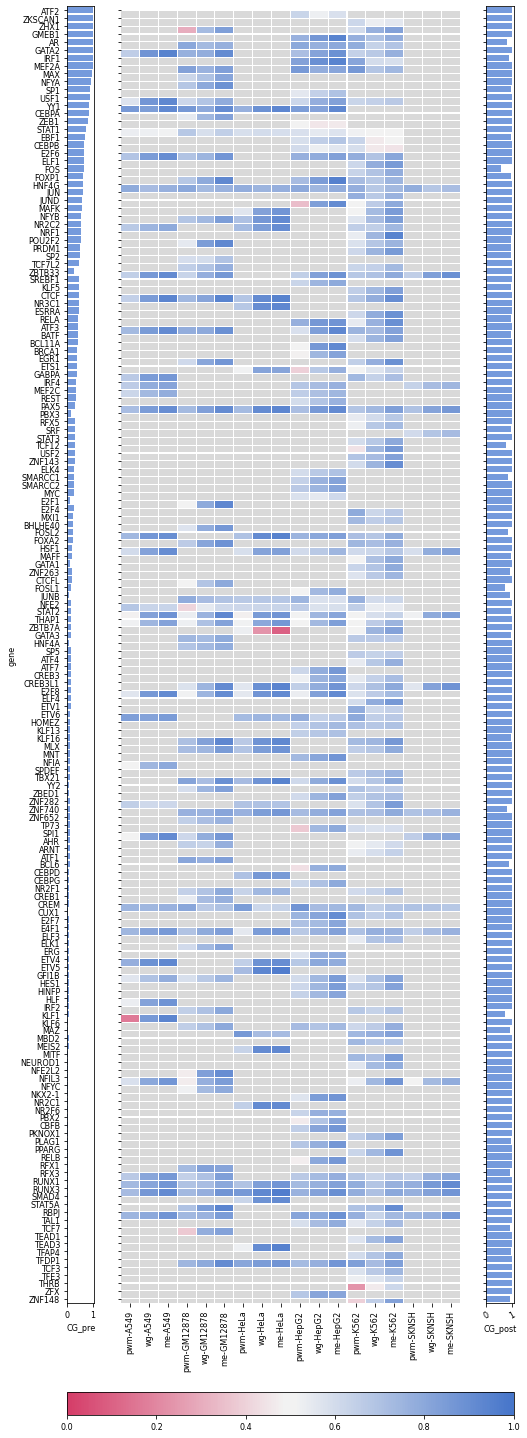

In [41]:
measure='auroc'

aurocs=pd.read_table('data/MotifPipeline/compare/sthlm_motif_0_QC_beta_red/test/all/all/sthlm_PRE_overall.txt',sep=',',usecols=[1,2,3,4,5,6,7,8,18,19,20,21,22,23,24,25,26,27],names=['cell','TF','mo_auroc','wgbs_auroc','me_auroc','mo_aupr','wgbs_aupr','me_aupr',
    'rand_mo_auroc','rand_wgbs_auroc','rand_me_auroc','rand_mo_aupr','rand_wgbs_aupr','rand_me_aupr','tr_wg_auroc','tr_me_auroc','tr_wg_aupr','tr_me_aupr'])
aurocs=aurocs[aurocs.cell!='0']

###change second last label to factor wgbs >10 reads threshold remove wgbs_auroc rather than tr_wg_auroc
if measure=='auroc':
    aurocs.drop(['mo_aupr','wgbs_aupr','me_aupr','rand_mo_aupr','rand_wgbs_aupr','rand_me_aupr','tr_wg_aupr','tr_me_aupr','rand_mo_auroc','rand_wgbs_auroc','rand_me_auroc','tr_wg_auroc','tr_me_auroc'],axis=1,inplace=True)
elif measure=='aupr':
    aurocs.drop(['mo_auroc','wgbs_auroc','me_auroc','rand_mo_auroc','rand_wgbs_auroc','rand_me_auroc','tr_wg_auroc','tr_me_auroc','rand_mo_aupr','rand_wgbs_aupr','rand_me_aupr','tr_wg_aupr','tr_me_aupr',],axis=1,inplace=True)

CGcont=pd.read_table('data/MotifPipeline/total_CGandNonCont.txt',sep=' ',names=['CG','total','motif','gene'])
CGcont['CG_pre']=CGcont['CG']/CGcont['total']
CGcont=CGcont[CGcont.CG_pre<=1]

CGcont2=pd.read_table('data/MotifPipeline/CGcont.txt',sep=' ',names=['CG','total','motif','gene'])
CGcont2['CG_post']=CGcont2['CG']/CGcont2['total']
heat=aurocs.pivot_table(index=['TF'], columns='cell')
heat=heat.dropna(axis=1, how='all')
heat=pd.DataFrame(heat.to_records())

heat.columns=['TF','me-A549','me-GM12878','me-HeLa','me-HepG2','me-K562','me-SKNSH',
             'pwm-A549','pwm-GM12878','pwm-HeLa','pwm-HepG2','pwm-K562','pwm-SKNSH',
             'wg-A549','wg-GM12878','wg-HeLa','wg-HepG2','wg-K562','wg-SKNSH']


heat=heat[['TF','pwm-A549','wg-A549','me-A549',
           'pwm-GM12878','wg-GM12878','me-GM12878',
           'pwm-HeLa', 'wg-HeLa','me-HeLa',
           'pwm-HepG2','wg-HepG2','me-HepG2',
           'pwm-K562','wg-K562','me-K562',
           'pwm-SKNSH','wg-SKNSH','me-SKNSH']]
heat55=heat
heat=heat.set_index('TF')
f,(ax1,ax2,ax3) = plt.subplots(1,3,sharey=True,figsize=(8, 30),gridspec_kw={'width_ratios':[0.08,1,0.08]})
rdgn=sns.diverging_palette(0.5, 255, sep=8, n=256,as_cmap=True)#sns.color_palette("RdBu",norm=DivergingNorm(0.5))

rdgn.set_bad(color='black', alpha=0.15)

CGcont=CGcont.sort_values(by=['CG_pre'],ascending=False)

g2 = sns.barplot(x='CG_pre',y='gene',color='cornflowerblue',data=CGcont[CGcont['gene'].isin(heat.index)].dropna(),ax=ax1,linewidth=.1,errwidth=0,capsize=0,ci=None)

g1 = sns.heatmap(heat,linewidth=.1,cmap=rdgn, vmin=0, vmax=1,cbar=False,mask=heat.isnull(),yticklabels=True,ax=ax2)#cbar_ax=cbar_ax,cbar_kws={"orientation": "horizontal"})
g1.set(ylabel=None)

g3 = sns.barplot(x='CG_post',y='gene',color='cornflowerblue',data=CGcont2[CGcont2['gene'].isin(heat.index)].dropna(),ax=ax3,linewidth=.1,errwidth=0,capsize=0,ci=None)
g3.set(ylabel=None)


mappable = g1.get_children()[0]
plt.colorbar(mappable, ax = [g2,g1,g3],orientation = 'horizontal',pad=.055) #.02 with 12x60, .03 for 12x40
plt.xticks(rotation=30)

plt.rcParams.update({'font.size': 8})
plt.savefig(outdir+"heat_S1.png",dpi=300,bbox_inches = "tight")
plt.show()


box=heat55
meltbox=pd.melt(box,id_vars=['TF'])


In [58]:

meltbox.columns=['TF','data - cell line','AUROC']


t0a, p0a = stats.ttest_ind(box['pwm-A549'].dropna(),box['wg-A549'].dropna())
t0b, p0b = stats.ttest_ind(box['pwm-A549'].dropna(),box['me-A549'].dropna())
t1a, p1a = stats.ttest_ind(box['pwm-GM12878'].dropna(),box['wg-GM12878'].dropna())
t1b, p1b = stats.ttest_ind(box['pwm-GM12878'].dropna(),box['me-GM12878'].dropna())
t2a, p2a = stats.ttest_ind(box['pwm-HeLa'].dropna(),box['wg-HeLa'].dropna())
t2b, p2b = stats.ttest_ind(box['pwm-HeLa'].dropna(),box['me-HeLa'].dropna())
t3a, p3a = stats.ttest_ind(box['pwm-HepG2'].dropna(),box['wg-HepG2'].dropna())
t3b, p3b = stats.ttest_ind(box['pwm-HepG2'].dropna(),box['me-HepG2'].dropna())
t4a, p4a = stats.ttest_ind(box['pwm-K562'].dropna(),box['wg-K562'].dropna())
t4b, p4b = stats.ttest_ind(box['pwm-K562'].dropna(),box['me-K562'].dropna())
t5a, p5a = stats.ttest_ind(box['pwm-SKNSH'].dropna(),box['wg-SKNSH'].dropna())
t5b, p5b = stats.ttest_ind(box['pwm-SKNSH'].dropna(),box['me-SKNSH'].dropna())


# initialise data of lists. 
ttest = {'WG ttest':[t0a,t1a,t2a,t3a,t4a,t5a], 'WG pvalue':[p0a,p1a,p2a,p3a,p4a,p5a], 'Me ttest':[t0b,t1b,t2b,t3b,t4b,t5b],'Me pvalue':[p0b,p1b,p2b,p3b,p4b,p5b]} 

# Creates pandas DataFrame. 
df_ttest = pd.DataFrame(ttest, index =['A549','GM12878', 'HeLa', 'HepG2', 'K562','SKNSH']) 

# df_ttest.to_csv(indir+"/test/camb_auroc_ttest.txt")
# meltbox.to_csv(indir+"/test/camb_auroc_meltbox.txt",sep='\t')
df_ttest

,WG ttest,WG pvalue,Me ttest,Me pvalue
A549,-5.947008,1.052179e-07,-7.469175,2.013972e-10
GM12878,-5.786277,5.688427e-08,-10.516397,8.334763e-19
HeLa,-5.656153,2.593818e-07,-5.654399,2.612511e-07
HepG2,-6.257098,3.899538e-09,-9.202276,2.821428e-16
K562,-3.117621,2.081113e-03,-8.310501,1.225221e-14
SKNSH,-4.296616,1.511755e-04,-5.597052,3.495836e-06


[Text(295.49090909090904, 0.5, '')]

<Figure size 216x2160 with 0 Axes>

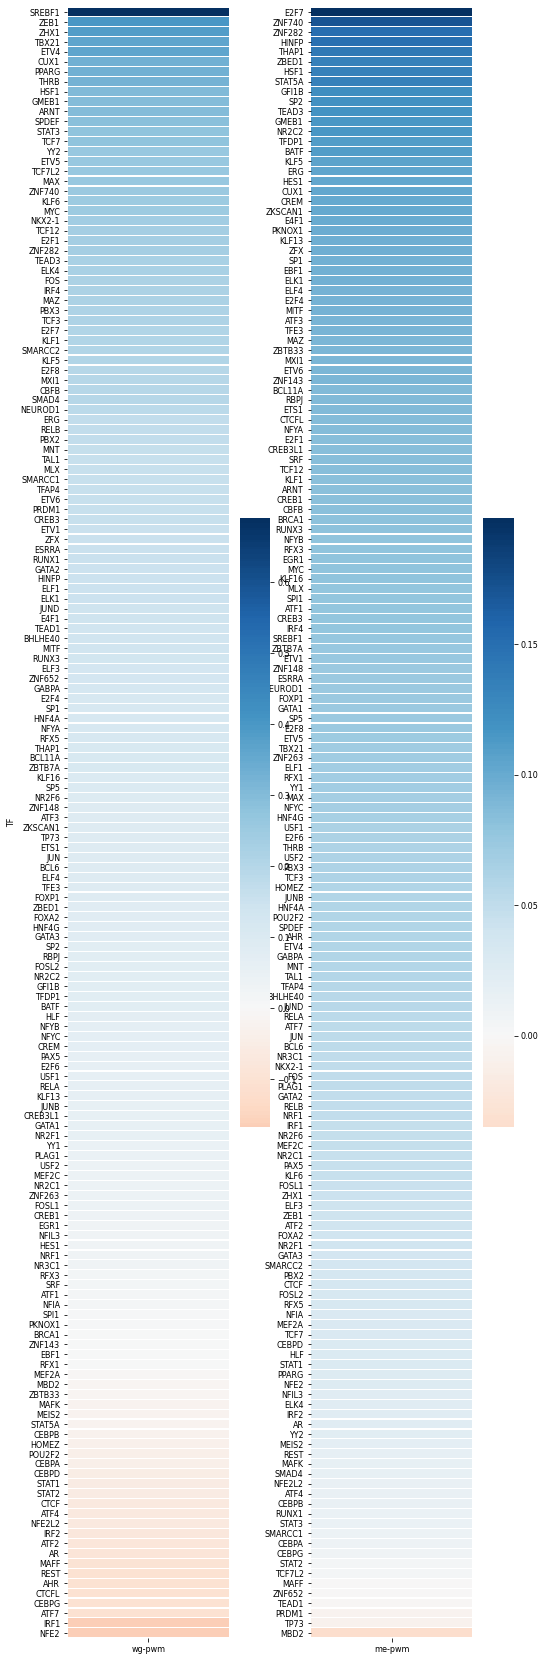

In [71]:
pwmmm=np.mean(heat[heat.columns[heat.columns.str.contains('pwm')]],axis=1)
wgbsss=np.mean(heat[heat.columns[heat.columns.str.contains('wg')]],axis=1)
meee=np.mean(heat[heat.columns[heat.columns.str.contains('me')]],axis=1)
heat2=np.transpose([wgbsss-pwmmm,meee-wgbsss])
heat2=pd.DataFrame(heat2,columns=['wg-pwm','me-pwm'],index=heat.index)
plt.figure(figsize=(3, 30))
heat3=heat2['me-pwm']
del heat2['me-pwm']


f,(ax1,ax2) = plt.subplots(1,2,sharey=False,figsize=(8, 30),gridspec_kw={'width_ratios':[1,1]})
rdgn=sns.diverging_palette(0.5, 255, sep=8, n=256,as_cmap=True)#sns.color_palette("RdBu",norm=DivergingNorm(0.5))

rdgn.set_bad(color='black', alpha=0.15)

CGcont=CGcont.sort_values(by=['CG_pre'],ascending=False)
heat2=heat2.sort_values(by='wg-pwm',ascending=False)
heat3=pd.DataFrame(heat3).sort_values(by='me-pwm',ascending=False)

g1 = sns.heatmap(heat2,linewidth=.1,center=0,cmap='RdBu',yticklabels=True,ax=ax1)#cbar_ax=cbar_ax,cbar_kws={"orientation": "horizontal"})

g2 = sns.heatmap(heat3,linewidth=.1,center=0,cmap='RdBu',yticklabels=True,ax=ax2)#cbar_ax=cbar_ax,cbar_kws={"orientation": "horizontal"})
g2.set(ylabel=None)


# Figure 3 and S2

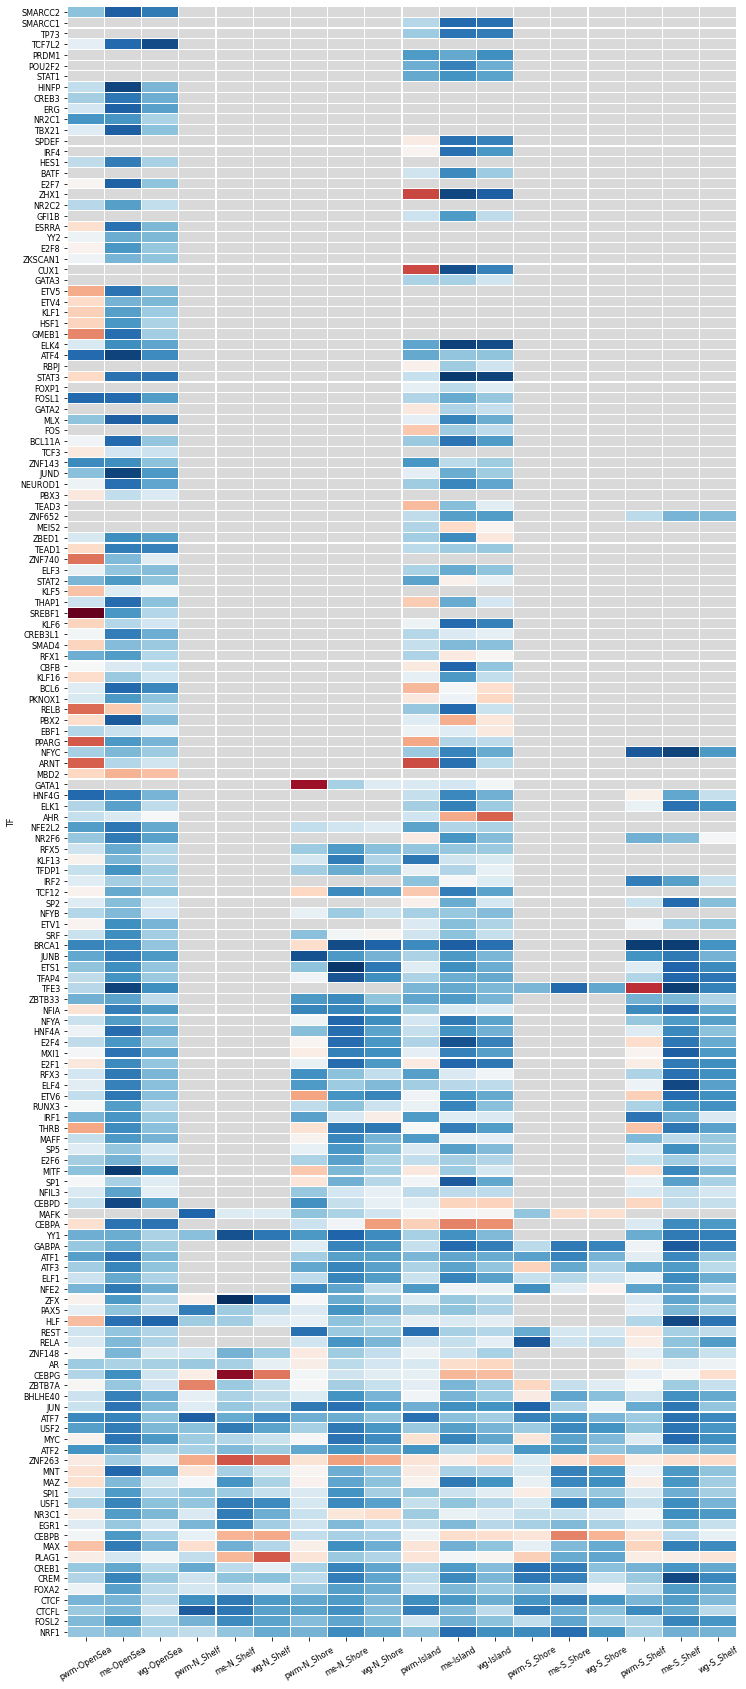

In [76]:
allbox=pd.DataFrame()
traces= glob.glob('data/MotifPipeline/compare/sthlm_motif_0_QC_beta_red/test/**/all/*.txt',recursive = True)
indices = [i for i, s in enumerate(traces) if 'sthlm_PRE_overall' in s]
measure='auroc'

for jac in (indices):
    trace=traces[jac]
    aurocs=pd.read_table(trace,sep=',',usecols=[1,2,3,4,5],names=['cell','TF','mo_auroc','wgbs_auroc','me_auroc'])#,'mo_aupr','wgbs_aupr','me_aupr','rand_mo_auroc','rand_wgbs_auroc','rand_me_auroc','rand_mo_aupr','rand_wgbs_aupr','rand_me_aupr','tr_wg_auroc','tr_me_auroc','tr_wg_aupr','tr_me_aupr'])
    aurocs=aurocs[aurocs.cell!='0']
    aurocs['region']=(trace.split('/')[5])
    
    allbox=pd.concat([allbox,aurocs],axis=0)

allbox=allbox[allbox['region']!='all']
heat=allbox.pivot_table(index=['TF'], columns='region')

heat['mean']=np.nanmean(heat,axis=1)
heat['count']=heat.isnull().sum(axis=1)

heat['weight']=heat['mean']*(heat['count'])
heat=heat.sort_values(by=['weight'],ascending=False)

heat=heat.dropna(axis=1, how='all')
del heat['count']
del heat['mean']
del heat['weight']

heat=pd.DataFrame(heat.to_records())

heat.columns=['TF','me-OpenSea','me-N_Shelf','me-N_Shore','me-Island','me-S_Shore','me-S_Shelf',
             'pwm-OpenSea','pwm-N_Shelf','pwm-N_Shore','pwm-Island','pwm-S_Shore','pwm-S_Shelf',
             'wg-OpenSea','wg-N_Shelf','wg-N_Shore','wg-Island','wg-S_Shore','wg-S_Shelf']

heat=heat[['TF','pwm-OpenSea','me-OpenSea','wg-OpenSea',
           'pwm-N_Shelf','me-N_Shelf','wg-N_Shelf',
           'pwm-N_Shore', 'me-N_Shore','wg-N_Shore',
           'pwm-Island','me-Island','wg-Island',
           'pwm-S_Shore','me-S_Shore','wg-S_Shore',
           'pwm-S_Shelf','me-S_Shelf','wg-S_Shelf']]
heat55=heat
heat=heat.set_index('TF')

plt.figure(figsize=(12, 30))

rdgn = plt.get_cmap("RdBu")
rdgn.set_bad(color='black', alpha=0.15)

g1 = sns.heatmap(heat,linewidth=.1,cmap=rdgn, cbar=False,mask=heat.isnull(),yticklabels=True)#cbar_ax=cbar_ax,cbar_kws={"orientation": "horizontal"})

mappable = ax.get_children()[0]
plt.colorbar(mappable, ax = [ax],orientation = 'horizontal',pad=.04) #.02 with 12x60, .03 for 12x40
plt.xticks(rotation=30)
outdir='../../d/tmp/redmo/data/'

plt.savefig(outdir+"S6.png",dpi=300,bbox_inches = "tight")


#     plt.savefig(outdir+"sthlm_"+measure+"_heat.png",dpi=300,bbox_inches = "tight")
plt.show

#     print([(heat55['pwm-OpenSea'].dropna().shape),(heat55['pwm-N_Shelf'].dropna().shape),(heat55['pwm-N_Shore'].dropna().shape),(heat55['pwm-Island'].dropna().shape),(heat55['pwm-S_Shore'].dropna().shape),(heat55['pwm-S_Shelf'].dropna().shape)])

box=heat55


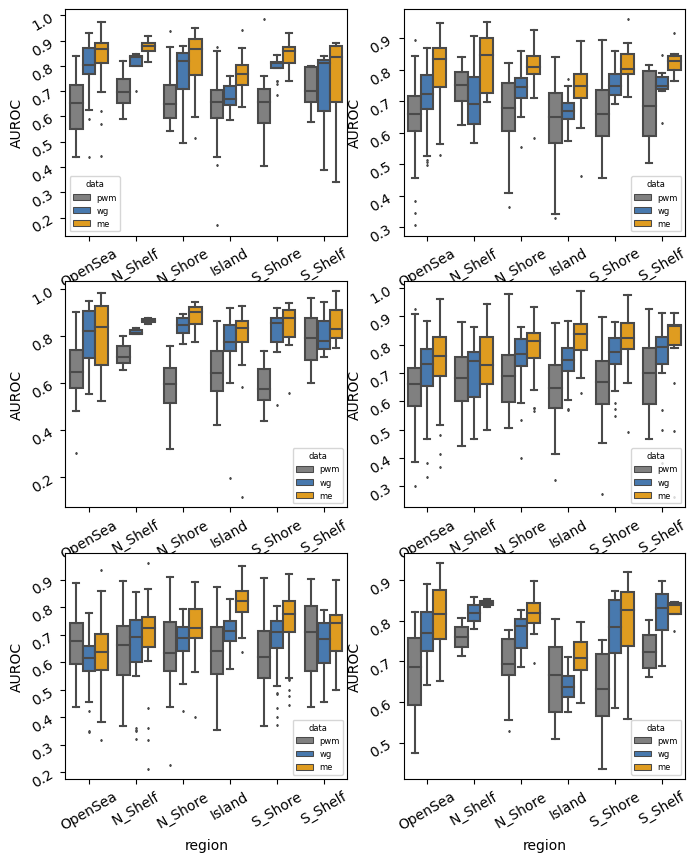

In [179]:
allbox['depth']=allbox.depth.astype(int)
allbox00=allbox.sort_values('cell', axis=0)
www=['OpenSea','N_Shelf','N_Shore','Island','S_Shore','S_Shelf']

aa=allbox00[allbox00['region']==www[0]]
bb=allbox00[allbox00['region']==www[1]]
cc=allbox00[allbox00['region']==www[2]]
dd=allbox00[allbox00['region']==www[3]]
ee=allbox00[allbox00['region']==www[4]]
ff=allbox00[allbox00['region']==www[5]]

allbox00=pd.concat([aa,bb,cc,dd,ee,ff])

aa=allbox00[allbox00['data']=='pwm']
bb=allbox00[allbox00['data']=='wg']
cc=allbox00[allbox00['data']=='me']
allbox00=pd.concat([aa,bb,cc])

zzz=['A549','GM12878', 'HeLa', 'HepG2', 'K562','SKNSH']
plt.style.use('default')
fig, axes = plt.subplots(nrows=3, ncols=2,figsize=(8,10))

plt.rcParams.update({'font.size': 6})

# for ax,cell in enumerate(pd.unique(allbox00['cell'])):
for i, ax in enumerate(axes.reshape(-1)):
    g=sns.boxplot(x='region',y='AUROC', data=allbox00[allbox00.cell==zzz[i]],ax=ax,hue='data',fliersize=1,palette=['grey',sns.xkcd_rgb["windows blue"],'orange','deeppink'])#.set(title = cell)
    ax.tick_params(labelrotation=30)


In [106]:
# t1b, p1b = stats.ttest_ind(aa['AUROC'].dropna(),bb['AUROC'].dropna())
def ttest_plot_region(allboxxx,datatype,regions=[]):

    allbox=allboxxx[allboxxx['data']==datatype]
    # allbox=allbox[allbox['data']=='wg']
    # allbox=allbox[allbox['data']=='me']
    aa=allbox[allbox['region']=='OpenSea']
    bb=allbox[allbox['region']=='N_Shelf']
    cc=allbox[allbox['region']=='N_Shore']
    dd=allbox[allbox['region']=='Island']
    ee=allbox[allbox['region']=='S_Shore']
    ff=allbox[allbox['region']=='S_Shelf']



    t0a, p0a = stats.ttest_ind(aa['AUROC'].dropna(),bb['AUROC'].dropna())
    t0b, p0b = stats.ttest_ind(aa['AUROC'].dropna(),cc['AUROC'].dropna())
    t1a, p1a = stats.ttest_ind(aa['AUROC'].dropna(),dd['AUROC'].dropna())
    t1b, p1b = stats.ttest_ind(aa['AUROC'].dropna(),ee['AUROC'].dropna())
    t2a, p2a = stats.ttest_ind(aa['AUROC'].dropna(),ff['AUROC'].dropna())

    t2b, p2b = stats.ttest_ind(bb['AUROC'].dropna(),cc['AUROC'].dropna())
    t3a, p3a = stats.ttest_ind(bb['AUROC'].dropna(),dd['AUROC'].dropna())
    t3b, p3b = stats.ttest_ind(bb['AUROC'].dropna(),ee['AUROC'].dropna())
    t4a, p4a = stats.ttest_ind(bb['AUROC'].dropna(),ff['AUROC'].dropna())

    t4b, p4b = stats.ttest_ind(cc['AUROC'].dropna(),dd['AUROC'].dropna())
    t5a, p5a = stats.ttest_ind(cc['AUROC'].dropna(),ee['AUROC'].dropna())
    t5b, p5b = stats.ttest_ind(cc['AUROC'].dropna(),ff['AUROC'].dropna())

    t6a, p6a = stats.ttest_ind(dd['AUROC'].dropna(),ee['AUROC'].dropna())
    t6b, p6b = stats.ttest_ind(dd['AUROC'].dropna(),ff['AUROC'].dropna())

    t7a, p7a = stats.ttest_ind(ee['AUROC'].dropna(),ff['AUROC'].dropna())

    # initialise data of lists. 
    ttest = {'OpenSea ttest':[t0a,t0b,t1a,t1b,t2a,1], 
             'N_Shelf ttest':[t2b,t3a,t3b,t4a,1,0],
            'N_Shore ttest':[t4b,t5a,t5b,1,0,0],
            'Island ttest':[t6a,t6b,1,0,0,0],
            'S_Shore ttest':[t7a,1,0,0,0,0],
            'S_Shelf ttest':[1,0,0,0,0,0]}

    pval = {'OpenSea pval':[p0a,p0b,p1a,p1b,p2a,1], 
             'N_Shelf pval':[p2b,p3a,p3b,p4a,1,0],
            'N_Shore pval':[p4b,p5a,p5b,1,0,0],
            'Island pval':[p6a,p6b,1,0,0,0],
            'S_Shore pval':[p7a,1,0,0,0,0],
            'S_Shelf pval':[1,0,0,0,0,0]} 

    # Creates pandas DataFrame. 
    df_ttest = pd.DataFrame(ttest, index =['S_Shelf','S_Shore', 'Island',  'N_Shore','N_Shelf','OpenSea']) 
    df_pval = pd.DataFrame(pval, index =['S_Shelf','S_Shore', 'Island',  'N_Shore','N_Shelf','OpenSea']) 

    df_pval.index='pwm_'+df_pval.index

    df_pval_pwm=df_pval
    return df_pval_pwm


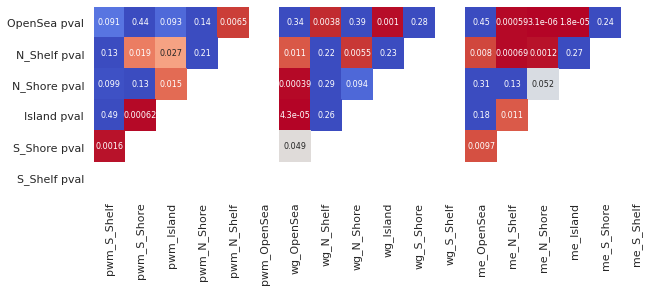

In [112]:
## try rotating
## https://gist.github.com/slowkow/5797728

df_pval_pwm=ttest_plot_region(allbox00,'pwm')
df_pval_wg=ttest_plot_region(allbox00,'wg')
df_pval_wg.index=['wg_OpenSea','wg_N_Shelf', 'wg_N_Shore', 'wg_Island', 'wg_S_Shore','wg_S_Shelf']
df_pval_me=ttest_plot_region(allbox00,'me')
df_pval_me.index=['me_OpenSea','me_N_Shelf', 'me_N_Shore', 'me_Island', 'me_S_Shore','me_S_Shelf']

allPval=pd.concat([df_pval_pwm,df_pval_wg,df_pval_me])

mask = np.zeros_like(allPval)
mask[np.triu_indices_from(allPval)] = True
cc=pd.DataFrame(np.flip(mask[0:6,0:6],axis=0))
mask=np.array(pd.concat([cc.T,cc.T,cc.T]))

sns.set(font_scale=1)

with sns.axes_style("white"):

    f, ax = plt.subplots(figsize=(10, 7))
    
    ax = sns.heatmap(allPval.T/2,annot=True,mask=mask.T,cbar=False,
                     vmax=.1, square=True,cmap='coolwarm_r',
                    annot_kws={"size":8})
#     plt.xticks(rotation=30)

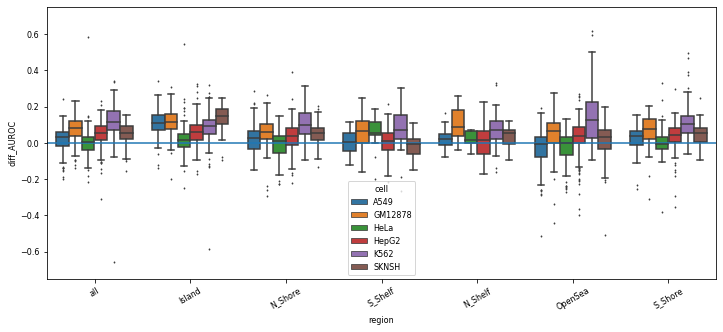

<Figure size 432x288 with 0 Axes>

In [80]:

allbox = pd.DataFrame()
traces= glob.glob('data/MotifPipeline/compare/sthlm_motif_0_QC_beta_red/test/**/all/*.txt',recursive = True)
indices = [i for i, s in enumerate(traces) if 'sthlm_auroc_meltbox' in s]
method='AUROC'

for jac in (indices):
    trace=traces[jac]
    buffer=(trace).split('/')[3]
    buffer=(buffer).split('_')[2]
    region=(trace).split('/')[5]
    depth=(trace).split('/')[6]
    meltbox=pd.read_csv(trace,sep='\t')
    meltbox['buffer']=buffer
    meltbox['region']=region
    meltbox['depth']=depth
    allbox=pd.concat([allbox,meltbox],axis=0)
allbox['cell_buff']=allbox['data - cell line']+'_'+allbox['buffer'].astype(str)
allbox['depth']=allbox['depth'].replace('all',0)

plt.figure(figsize=(12, 5))
plt.xticks(rotation=30)
allbox['data']=allbox['data - cell line'].str.split('-').str[0].tolist()
type=pd.unique(allbox['data'])
allbox['cell']=allbox['data - cell line'].str.split('-').str[1].tolist()
cells=pd.unique(allbox['cell'])

allbox['depth']=allbox.depth.astype(int)
allbox2=allbox.sort_values('cell', axis=0)

aa=allbox2[allbox2['data']=='pwm']
bb=allbox2[allbox2['data']=='wg']
cc=allbox2[allbox2['data']=='me']
dd=(cc.merge(bb,left_on=['TF','region'],right_on=['TF','region']))
dd['diff_AUROC']=(dd['AUROC_x']-dd['AUROC_y'])
dd['data']='me-wg'
dd['depth']=dd['depth_y']
dd['cell']=dd['cell_y']
allbox2=pd.concat([dd])
g=sns.boxplot(x='region',y='diff_AUROC', data=allbox2,hue='cell',fliersize=1)#.set(title = cell)
plt.axhline(y=0, xmin=-1, xmax=6)

g.set(ylim=(-.75, .75))

plt.show()
outdir='../../d/tmp/redmo/data/'

plt.savefig(outdir+"S4B.png",dpi=300,bbox_inches = "tight")


# Figure 4 and S3

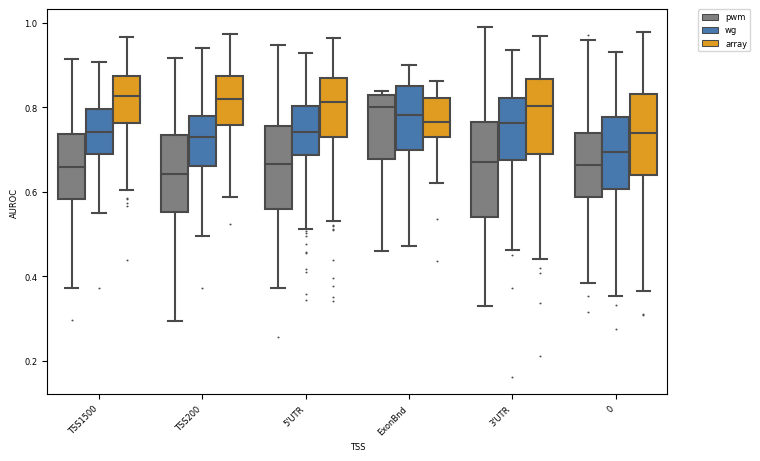

In [180]:
# def plot_allPredScore(directory,agg_meth='mean',method='auroc',region=None,depth=None):
allbox = pd.DataFrame()
www=['TSS1500','TSS200',  "5'UTR",'ExonBnd',"3'UTR","0"]
indir='../../d/tmp/redmo/data/MotifPipeline/sthlm_motif_0_QCbeta'
traces= glob.glob(indir+'/test/*_PRE_window_methyl.txt',recursive = True)
# indices = [i for i, s in enumerate(traces) if 'sthlm_auroc_meltbox' in s]
method='AUROC'

for i,trace in enumerate(traces):

    TSS=(traces[i]).split('/')[9]
    TSS=(TSS).split('_')[0]

    meltbox=pd.read_csv(traces[i],sep=',',names=['cell','TF','pwm','wg','array','size','yes'])
    meltbox['TSS']=TSS

    allbox=pd.concat([allbox,meltbox],axis=0)
allbox00=pd.melt(allbox, id_vars=['TF','cell','TSS','size','yes'], value_vars=['pwm','wg','array'])
allbox11=pd.melt(allbox, id_vars=['TF','cell','TSS','size','yes','pwm'], value_vars=['wg','array'])

plt.figure(figsize=(8, 5))
plt.grid(False)
allbox00=allbox00[allbox00.cell!='overlap']
allbox00['AUROC']=allbox00['value']
del allbox00['value']
aa=allbox00[allbox00['TSS']==www[0]]
bb=allbox00[allbox00['TSS']==www[1]]
cc=allbox00[allbox00['TSS']==www[2]]
dd=allbox00[allbox00['TSS']==www[3]]
ee=allbox00[allbox00['TSS']==www[4]]
ff=allbox00[allbox00['TSS']==www[5]]
allbox00=pd.concat([aa,bb,cc,dd,ee,ff])

j=sns.boxplot(x='TSS',y=method.upper(), data=allbox00,hue='variable',fliersize = .5,palette=['grey',sns.xkcd_rgb["windows blue"],'orange'])
j.set_xticklabels(j.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.title('Array')
plt.show()
# plt.xticks(rotation=30)
allboxxx=allbox


<function matplotlib.pyplot.show(close=None, block=None)>

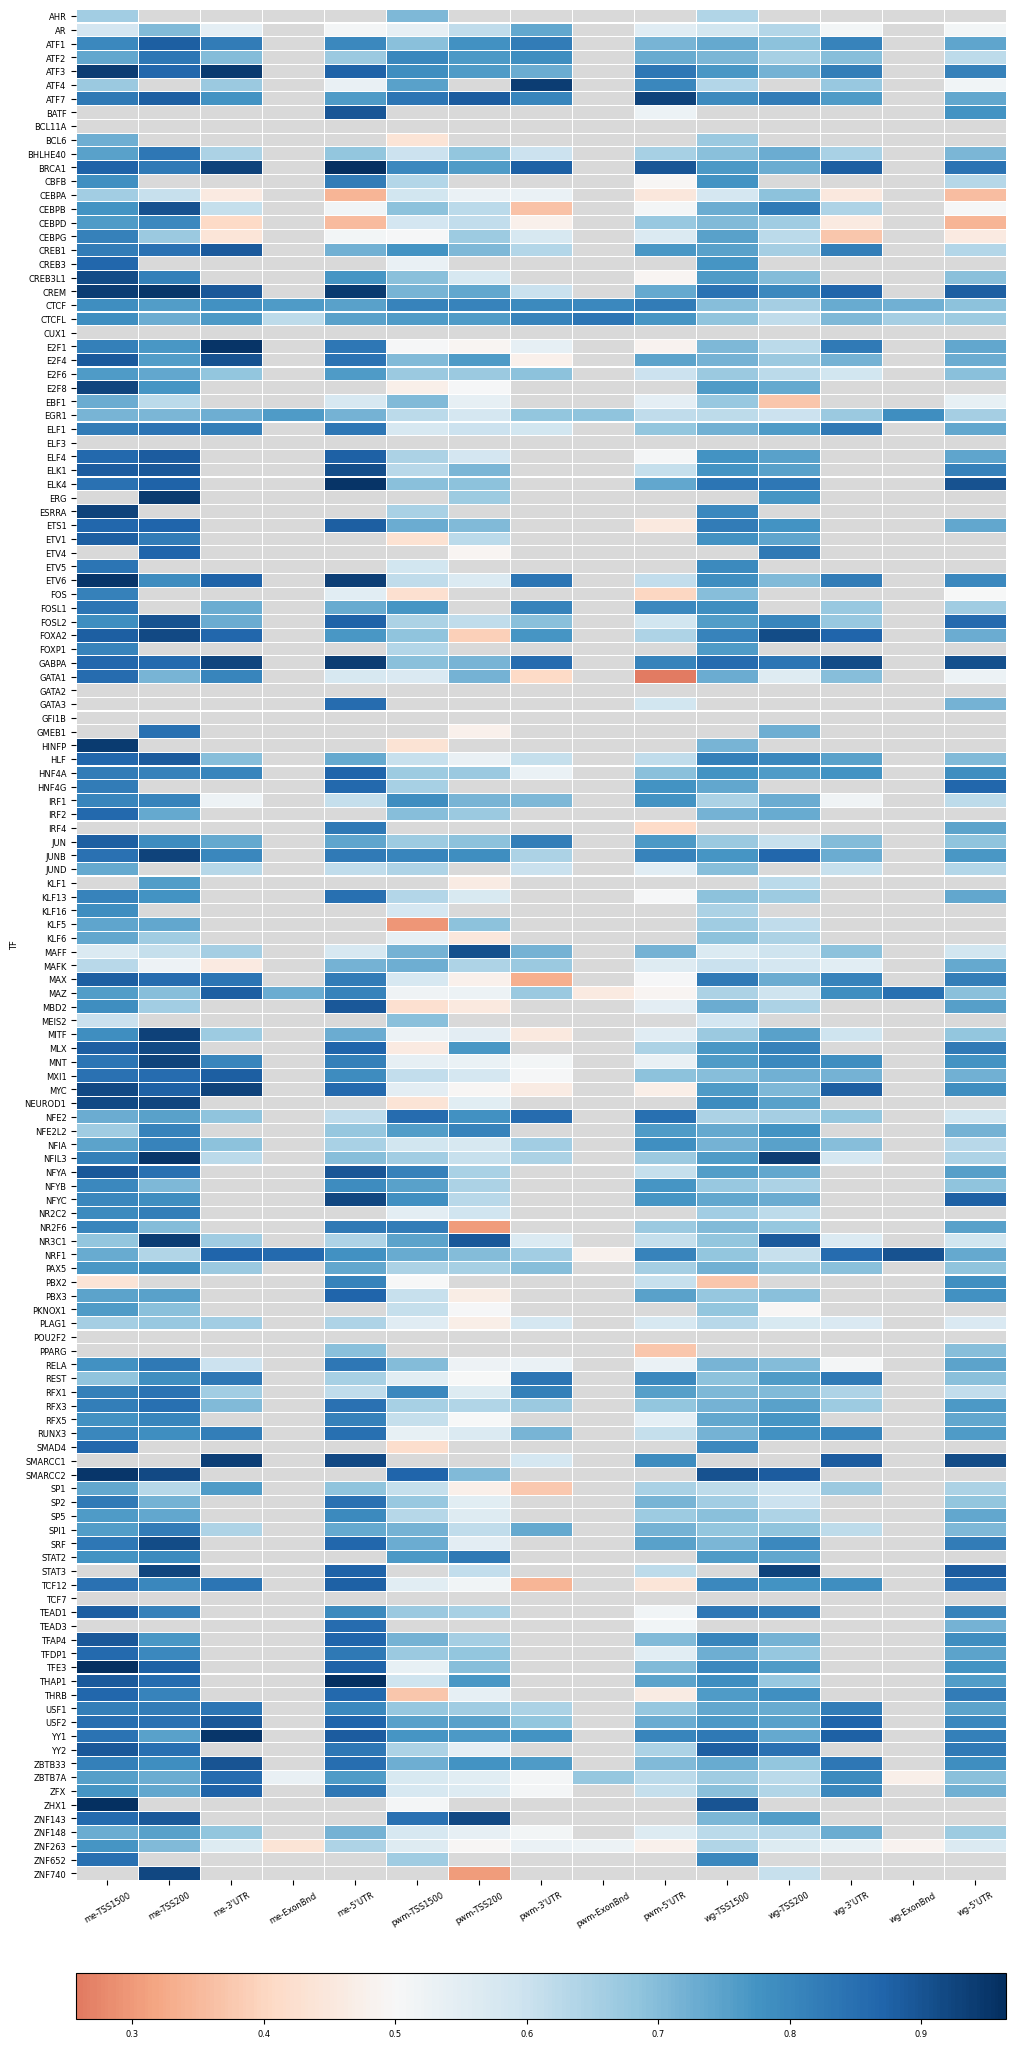

In [181]:
del allbox['size']
del allbox['yes']
del allbox['cell']
tssheat=allbox.pivot_table(index=['TF'], columns=['TSS'],aggfunc='first')

tssheat.columns=['me-0',"me-3'UTR","me-5'UTR",'me-ExonBnd','me-TSS1500','me-TSS200',
              'pwm-0',"pwm-3'UTR","pwm-5'UTR",'pwm-ExonBnd','pwm-TSS1500','pwm-TSS200',
            'wg-0',"wg-3'UTR","wg-5'UTR",'wg-ExonBnd','wg-TSS1500','wg-TSS200']

tssheat=tssheat[['me-TSS1500','me-TSS200',"me-3'UTR",'me-ExonBnd',"me-5'UTR",
          'pwm-TSS1500','pwm-TSS200',"pwm-3'UTR",'pwm-ExonBnd',"pwm-5'UTR",
          'wg-TSS1500','wg-TSS200',"wg-3'UTR",'wg-ExonBnd',"wg-5'UTR"]]
heat55=tssheat


plt.figure(figsize=(12, 30))

rdgn = plt.get_cmap("RdBu")
rdgn.set_bad(color='black', alpha=0.15)
ax = sns.heatmap(tssheat, center=.5,linewidth=.1,cmap=rdgn, cbar=False)#cbar_ax=cbar_ax,cbar_kws={"orientation": "horizontal"})
mappable = ax.get_children()[0]
plt.colorbar(mappable, ax = [ax],orientation = 'horizontal',pad=.04) #.02 with 12x60, .03 for 12x40
plt.xticks(rotation=30)

plt.show



In [182]:
# t1b, p1b = stats.ttest_ind(aa['AUROC'].dropna(),bb['AUROC'].dropna())
def ttest_plot_TSS(allboxxx,datatype,regions=[]):
    allbox=allboxxx[allboxxx['variable']==datatype]
    aa=allbox[allbox['TSS']=='TSS1500']
    bb=allbox[allbox['TSS']=='TSS200']
    cc=allbox[allbox['TSS']=="5'UTR"]
    dd=allbox[allbox['TSS']=='ExonBnd']
    ee=allbox[allbox['TSS']=="3'UTR"]
    ff=allbox[allbox['TSS']=='0']

    t0a, p0a = stats.ttest_ind(aa['AUROC'].dropna(),bb['AUROC'].dropna())
    t0b, p0b = stats.ttest_ind(aa['AUROC'].dropna(),cc['AUROC'].dropna())
    t1a, p1a = stats.ttest_ind(aa['AUROC'].dropna(),dd['AUROC'].dropna())
    t1b, p1b = stats.ttest_ind(aa['AUROC'].dropna(),ee['AUROC'].dropna())
    t2a, p2a = stats.ttest_ind(aa['AUROC'].dropna(),ff['AUROC'].dropna())

    t2b, p2b = stats.ttest_ind(bb['AUROC'].dropna(),cc['AUROC'].dropna())
    t3a, p3a = stats.ttest_ind(bb['AUROC'].dropna(),dd['AUROC'].dropna())
    t3b, p3b = stats.ttest_ind(bb['AUROC'].dropna(),ee['AUROC'].dropna())
    t4a, p4a = stats.ttest_ind(bb['AUROC'].dropna(),ff['AUROC'].dropna())

    t4b, p4b = stats.ttest_ind(cc['AUROC'].dropna(),dd['AUROC'].dropna())
    t5a, p5a = stats.ttest_ind(cc['AUROC'].dropna(),ee['AUROC'].dropna())
    t5b, p5b = stats.ttest_ind(cc['AUROC'].dropna(),ff['AUROC'].dropna())

    t6a, p6a = stats.ttest_ind(dd['AUROC'].dropna(),ee['AUROC'].dropna())
    t6b, p6b = stats.ttest_ind(dd['AUROC'].dropna(),ff['AUROC'].dropna())

    t7a, p7a = stats.ttest_ind(ee['AUROC'].dropna(),ff['AUROC'].dropna())

    # initialise data of lists. 
    ttest = {'TSS1500 ttest':[1,t0a,t0b,t1a,t1b,t2a], 
             "TSS200 ttest":[0,1,t2b,t3a,t3b,t4a],
            "5'UTR ttest":[0,0,1,t4b,t5a,t5b],
             "ExonBnd ttest":[0,0,0,1,t6a,t6b],
            "3'UTR ttest":[0,0,0,0,1,t7a],
            '0 ttest':[0,0,0,0,0,1]}

    pval = {'TSS1500 pval':[1,p0a,p0b,p1a,p1b,p2a], 
             "TSS200 pval":[0,1,p2b,p3a,p3b,p4a],
            "5'UTR pval":[0,0,1,p4b,p5a,p5b],
             "ExonBnd pval":[0,0,0,1,p6a,p6b],
            "3'UTR pval":[0,0,0,0,1,p7a],
            '0 pval':[0,0,0,0,0,1]} 

    # Creates pandas DataFrame. 
    df_ttest = pd.DataFrame(ttest, index =['TSS1500','TSS200', "3'UTR", 'ExonBnd',"5'UTR",'0']) 
    df_pval = pd.DataFrame(pval, index =['TSS1500','TSS200', "3'UTR", 'ExonBnd',"5'UTR",'0']) 
    df_ttest=df_ttest.iloc[::-1]
    df_pval=df_pval.iloc[::-1]

    df_pval.index='pwm_'+df_pval.index

    df_pval_pwm=df_pval
    return df_pval_pwm


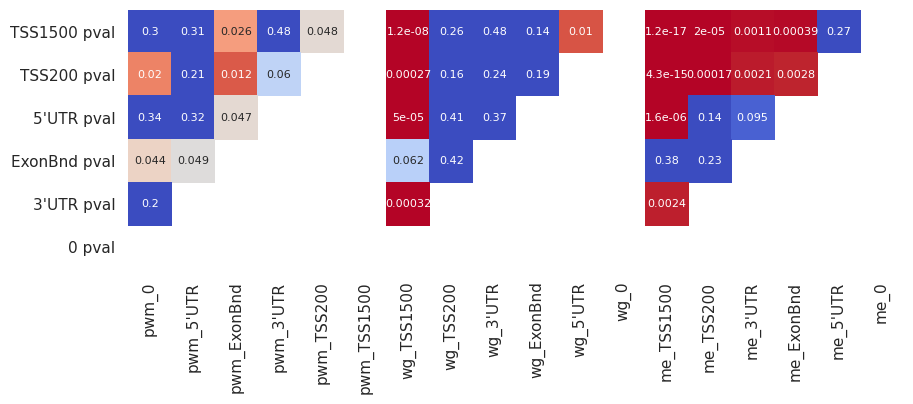

In [183]:
## try rotating
## https://gist.github.com/slowkow/5797728

df_pval_pwm=ttest_plot_TSS(allbox00,'pwm')
df_pval_wg=ttest_plot_TSS(allbox00,'wg')
df_pval_wg.index=['wg_TSS1500','wg_TSS200',"wg_3'UTR",'wg_ExonBnd',"wg_5'UTR",'wg_0']
df_pval_me=ttest_plot_TSS(allbox00,'array')
df_pval_me.index=['me_TSS1500','me_TSS200',"me_3'UTR",'me_ExonBnd',"me_5'UTR",'me_0']

allPval=pd.concat([df_pval_pwm,df_pval_wg,df_pval_me])

mask = np.zeros_like(allPval)
mask[np.triu_indices_from(allPval)] = True
cc=pd.DataFrame(np.flip(mask[0:6,0:6],axis=0))
mask=np.array(pd.concat([cc.T,cc.T,cc.T]))

sns.set(font_scale=1)

with sns.axes_style("white"):

    f, ax = plt.subplots(figsize=(10, 7))
    
    ax = sns.heatmap(allPval.T/2,annot=True,mask=mask.T,cbar=False,
                     vmax=.1, square=True,cmap='coolwarm_r',
                    annot_kws={"size":8})
#     plt.xticks(rotation=30)

# Figure 5A

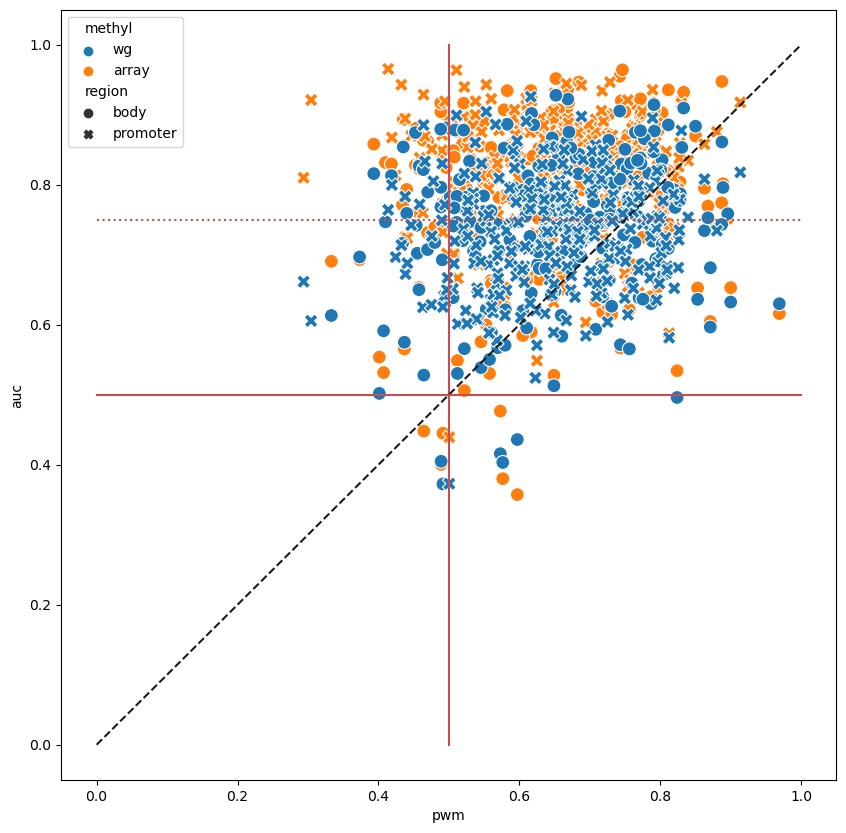

In [187]:


plt.figure(figsize=(10, 10))
allbox11['auc']=allbox11['value']
allbox11['methyl']=allbox11['variable']

aa=allbox11[allbox11['TSS']==www[0]]
bb=allbox11[allbox11['TSS']==www[1]]
cc=allbox11[allbox11['TSS']==www[2]]
dd=allbox11[allbox11['TSS']==www[3]]
ee=allbox11[allbox11['TSS']==www[4]]
aa['region']='promoter'
bb['region']='promoter'
cc['region']='body'
dd['region']='body'
ee['region']='body'
allbox11=pd.concat([aa,bb,cc,dd,ee])
allboxxx11=allbox11.groupby(['methyl','region','cell','TF']).mean()
plt.style.use('default')

sns.scatterplot(
    data=allboxxx11, x="pwm", y='auc', style='region', hue="methyl",hue_order=['wg','array'],
    sizes=(200, 200), legend='full',s=100
)
plt.plot([0,1], [0.75,0.75], 'r:')#.add_legend().set_axis_labels("x", "y")
plt.plot([0.5,0.5],[0,1], 'r-')
plt.plot([0, 1], [0, 1], 'k--')
plt.plot([0,1], [0.5,0.5], 'r-')
# ax.fill_between(.5*invData2.auc, [0.5],1, alpha=0.2)

In [203]:
# del allboxxx11['size'], allboxxx11['yes']
allboxxx11[(allboxxx11['auc']<0.55) & (allboxxx11['pwm']<0.55)]

pwm     value       auc
methyl region   cell    TF                                  
array  body     A549    CEBPB   0.464354  0.447948  0.447948
                HeLa    CEBPB   0.521917  0.505930  0.505930
                HepG2   CEBPA   0.488964  0.400495  0.400495
                        CEBPD   0.491505  0.444960  0.444960
                K562    CEBPB   0.407315  0.531595  0.531595
                        ZNF263  0.512064  0.548821  0.548821
       promoter K562    PBX2    0.500639  0.439336  0.439336
wg     body     A549    CEBPB   0.464354  0.528006  0.528006
                GM12878 EBF1    0.545568  0.538702  0.538702
                HepG2   CEBPA   0.488964  0.404890  0.404890
                        CEBPD   0.491505  0.372503  0.372503
                K562    FOS     0.401250  0.501875  0.501875
                        ZNF263  0.512064  0.530347  0.530347
       promoter K562    PBX2    0.500639  0.372925  0.372925

# Figure 5B

In [205]:
def plot_allPredScore(indir,agg_meth='mean',method='auroc',region=None,depth=None):
    allbox = pd.DataFrame()
    www=['TSS1500','TSS200',  "5'UTR",'ExonBnd',"3'UTR","0"]
    
    traces= glob.glob(indir+'*_PRE_window_methyl.txt',recursive = True)
    method='AUROC'

    for i,trace in enumerate(traces):

        TSS=(traces[i]).split('/')[9]
        TSS=(TSS).split('_')[0]

        meltbox=pd.read_csv(traces[i],sep=',',names=['cell','TF','pwm','wg','array','alt_wg','alt_array','rand','size','yes'])
        meltbox['TSS']=TSS

        allbox=pd.concat([allbox,meltbox],axis=0)
    allbox00=pd.melt(allbox, id_vars=['TF','cell','TSS','size','yes'], value_vars=['pwm','wg','array','alt_wg','alt_array','rand'])
    allbox11=pd.melt(allbox, id_vars=['TF','cell','TSS','size','yes','pwm'], value_vars=['wg','array','alt_wg','alt_array','rand'])
    return allbox,allbox00, allbox11

      ttest          pval
0 -5.212411  9.775237e-07
1 -5.549423  2.276084e-07
2 -3.380534  1.157889e-03
3 -3.850808  2.481468e-04


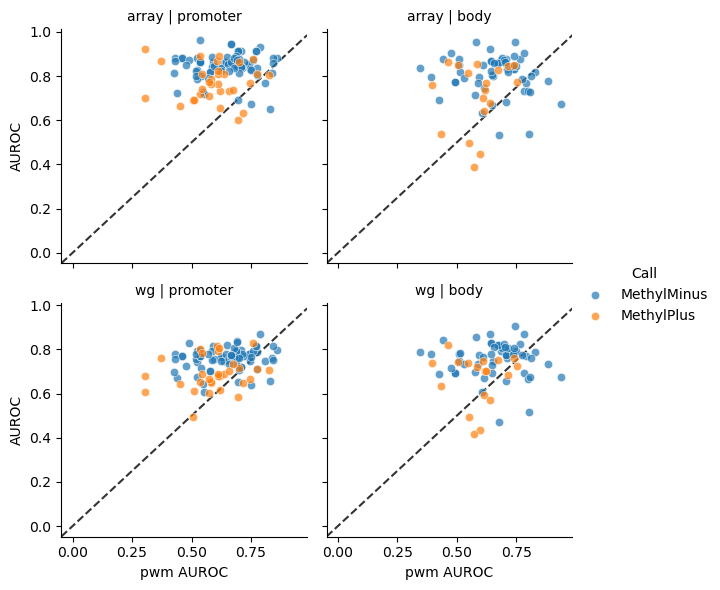

In [208]:

indir='../../d/tmp/redmo/data/MotifPipeline/sthlm_motif_0_QCbeta'
traces=[x[0] for x in os.walk(indir)]
www=["0",'TSS1500','TSS200',"5'UTR",'ExonBnd',"3'UTR"]
model_name=traces[2]

allbox,allbox00, allbox11=plot_allPredScore(model_name+'/',agg_meth='mean',method='auroc',region=None,depth=None)

df_sheet_index = pd.read_csv('~/mili_benchmark/archive/R/aaj2239_Yin_SM_tables_S3.txt', sep='\t',header=0)

cc=pd.DataFrame(df_sheet_index)
cc=cc.dropna(how='all')
cc=cc.drop_duplicates()
cc.drop_duplicates(subset=['TF name'], keep='last') ##try last too
allboxxx22=allbox11.groupby(['variable','TSS','TF']).mean() #remove 'cell'
allboxxx22=allboxxx22.reset_index()
yyy=allboxxx22[allboxxx22['variable']=='array']
xxx=allboxxx22[allboxxx22['variable']=='wg']

allboxxx22=pd.concat([yyy,xxx])

aa=pd.merge(allboxxx22,cc,left_on='TF',right_on='TF name')
aaa=aa[aa['Call']=='MethylMinus']
bbb=aa[aa['Call']=='MethylPlus']
aa=pd.concat([aaa,bbb])#,ccc])

aaaa=aa[aa['TSS']==www[0]]
bb=aa[aa['TSS']==www[1]]
cc=aa[aa['TSS']==www[2]]
dd=aa[aa['TSS']==www[3]]
ee=aa[aa['TSS']==www[4]]
ff=aa[aa['TSS']==www[5]]
aaaa['region']='body'#+aaaa.variable
bb['region']='promoter'#+bb.variable
cc['region']='promoter'#+cc.variable
dd['region']='body'#+dd.variable
ee['region']='body'#+ee.variable
ff['region']='body'#+ff.variable
aaxx=pd.concat([bb,cc,dd,ee,ff])
aaxx['AUROC']=aaxx['value']

aaxx.reset_index(inplace=True)
a=aaxx[aaxx['region']=='promoter']
aa=a[a['variable']=='array']
aaa0=aa[aa['Call']=='MethylPlus']
aaa1=aa[aa['Call']=='MethylMinus']
bb=a[a['variable']=='wg']
bbb0=bb[bb['Call']=='MethylPlus']
bbb1=bb[bb['Call']=='MethylMinus']

c=aaxx[aaxx['region']=='body']
cc=c[c['variable']=='array']
ccc0=cc[cc['Call']=='MethylPlus']
ccc1=cc[cc['Call']=='MethylMinus']
dd=c[c['variable']=='wg']
ddd0=dd[dd['Call']=='MethylPlus']
ddd1=dd[dd['Call']=='MethylMinus']

t1, p1 = stats.ttest_ind(aaa0.value.dropna(),aaa1.value.dropna())
t2, p2 = stats.ttest_ind(bbb0.value.dropna(),bbb1.value.dropna())
t3, p3 = stats.ttest_ind(ccc0.value.dropna(),ccc1.value.dropna())
t4, p4 = stats.ttest_ind(ddd0.value.dropna(),ddd1.value.dropna())

def annotate(data, *hue,**kws):
    t,p = stats.ttest_ind(data[data['Call']==hue].value.dropna(),data[data['Call']==hue].value.dropna())

    ax = plt.gca()
    print(p)
    ax.text(.1, .6, f"pval = {p}", transform=ax.transAxes)


g = sns.FacetGrid(aaxx, col="region",row='variable', hue="Call")#,style="region",)
g.map(sns.scatterplot, "pwm", "AUROC", alpha=.7)
for ax in g.axes.flat:
    ax.axline((0, 0), slope=1, c=".2", ls="--", zorder=0)
g.add_legend()
g.set_axis_labels("pwm AUROC", "AUROC")
g.set_titles(col_template="{col_name}", row_template="{row_name}")


cc=pd.DataFrame([[t1,p1],[t2,p2],[t3,p3],[t4,p4]])
cc.columns=['ttest','pval']
print(cc)


# Figure S4

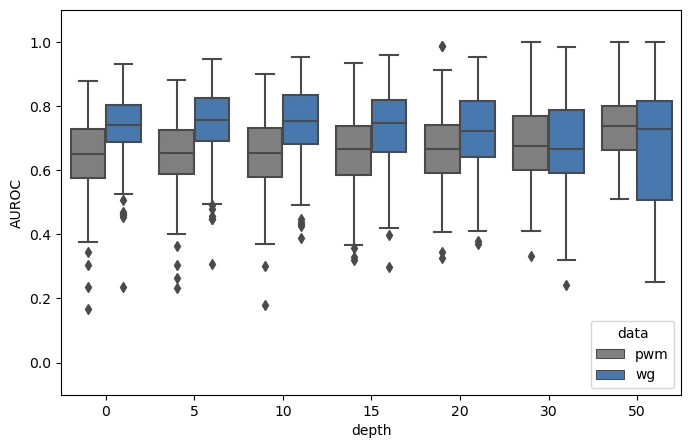

In [209]:
allbox = pd.DataFrame()
traces= glob.glob('data/MotifPipeline/compare/sthlm_motif_0_QC_beta_red/test/all/**/*.txt',recursive = True)
indices = [i for i, s in enumerate(traces) if 'sthlm_auroc_meltbox' in s]
method='AUROC'

for jac in (indices):
    trace=traces[jac]
    buffer=(trace).split('/')[3]
    buffer=(buffer).split('_')[2]
    region=(trace).split('/')[5]
    depth=(trace).split('/')[6]
    meltbox=pd.read_csv(trace,sep='\t')
    meltbox['buffer']=buffer
    meltbox['region']=region
    meltbox['depth']=depth
    allbox=pd.concat([allbox,meltbox],axis=0)
allbox['cell_buff']=allbox['data - cell line']+'_'+allbox['buffer'].astype(str)
allbox['depth']=allbox['depth'].replace('all',0)

allbox['data']=allbox['data - cell line'].str.split('-').str[0].tolist()
type=pd.unique(allbox['data'])
allbox['cell']=allbox['data - cell line'].str.split('-').str[1].tolist()
cells=pd.unique(allbox['cell'])

allbox['depth']=allbox.depth.astype(int)
allbox=allbox.sort_values('depth', axis=0)

plt.figure(figsize=(8, 5))
allbox2=allbox

aa=allbox2[allbox2['data']=='pwm']
bb=allbox2[allbox2['data']=='wg']
cc=allbox2[allbox2['data']=='me']

allbox2=pd.concat([aa,bb])

g=sns.boxplot(x='depth',y=method.upper(), data=allbox2,hue='data',palette=['grey',sns.xkcd_rgb["windows blue"],'orange','deeppink'])
g.set(ylim=(-0.1, 1.1))
plt.rcParams.update({'font.size': 8})
plt.show()
allboxxx=allbox


In [210]:
def ttest_plot_depth(allboxxx,datatype,regions=[]):

    allbox=allboxxx[allboxxx['data']==datatype]
 
    aa=allbox[allbox['depth']==0]
    bb=allbox[allbox['depth']==5]
    cc=allbox[allbox['depth']==10]
    dd=allbox[allbox['depth']==15]
    ee=allbox[allbox['depth']==20]
    ff=allbox[allbox['depth']==30]
    gg=allbox[allbox['depth']==50]



    t0a, p0a = stats.ttest_ind(aa['AUROC'].dropna(),bb['AUROC'].dropna())
    t0b, p0b = stats.ttest_ind(aa['AUROC'].dropna(),cc['AUROC'].dropna())
    t1a, p1a = stats.ttest_ind(aa['AUROC'].dropna(),dd['AUROC'].dropna())
    t1b, p1b = stats.ttest_ind(aa['AUROC'].dropna(),ee['AUROC'].dropna())
    t2a, p2a = stats.ttest_ind(aa['AUROC'].dropna(),ff['AUROC'].dropna())
    t2aa, p2aa = stats.ttest_ind(aa['AUROC'].dropna(),gg['AUROC'].dropna())


    t2b, p2b = stats.ttest_ind(bb['AUROC'].dropna(),cc['AUROC'].dropna())
    t3a, p3a = stats.ttest_ind(bb['AUROC'].dropna(),dd['AUROC'].dropna())
    t3b, p3b = stats.ttest_ind(bb['AUROC'].dropna(),ee['AUROC'].dropna())
    t4a, p4a = stats.ttest_ind(bb['AUROC'].dropna(),ff['AUROC'].dropna())
    t4aa, p4aa = stats.ttest_ind(bb['AUROC'].dropna(),gg['AUROC'].dropna())


    t4b, p4b = stats.ttest_ind(cc['AUROC'].dropna(),dd['AUROC'].dropna())
    t5a, p5a = stats.ttest_ind(cc['AUROC'].dropna(),ee['AUROC'].dropna())
    t5b, p5b = stats.ttest_ind(cc['AUROC'].dropna(),ff['AUROC'].dropna())
    t5bb, p5bb = stats.ttest_ind(cc['AUROC'].dropna(),gg['AUROC'].dropna())


    t6a, p6a = stats.ttest_ind(dd['AUROC'].dropna(),ee['AUROC'].dropna())
    t6b, p6b = stats.ttest_ind(dd['AUROC'].dropna(),ff['AUROC'].dropna())
    t6bb, p6bb = stats.ttest_ind(dd['AUROC'].dropna(),gg['AUROC'].dropna())

    t7a, p7a = stats.ttest_ind(ee['AUROC'].dropna(),ff['AUROC'].dropna())
    t7aa, p7aa = stats.ttest_ind(ee['AUROC'].dropna(),gg['AUROC'].dropna())

    t8a, p8a = stats.ttest_ind(ee['AUROC'].dropna(),gg['AUROC'].dropna())


    # initialise data of lists. 
    ttest = {'0 ttest':[t0a,t0b,t1a,t1b,t2a,t2aa,1], 
             '5 ttest':[t2b,t3a,t3b,t4a,t4aa,1,0],
            '10 ttest':[t4b,t5a,t5b,t5bb,1,0,0],
            '15 ttest':[t6a,t6b,t6bb,1,0,0,0],
            '20 ttest':[t7a,t7aa,1,0,0,0,0],
            '30 ttest':[t8a,1,0,0,0,0,0],
            '50 ttest':[1,0,0,0,0,0,0]}

    pval = {'0 pval':[p0a,p0b,p1a,p1b,p2a,p2aa,1], 
             '5 pval':[p2b,p3a,p3b,p4a,p4aa,1,0],
            '10 pval':[p4b,p5a,p5b,p5bb,1,0,0],
            '15 pval':[p6a,p6b,p6bb,1,0,0,0],
            '20 pval':[p7a,p7aa,1,0,0,0,0],
            '30 pval':[p8a,1,0,0,0,0,0],
            '50 pval':[1,0,0,0,0,0,0]} 

    # Creates pandas DataFrame. 
    df_ttest = pd.DataFrame(ttest, index =['50','30', '20',  '15','10','5','0']) 
    df_pval = pd.DataFrame(pval, index =['50','30', '20',  '15','10','5','0']) 

    # df_ttest = pd.DataFrame(ttest, index =['OpenSea','N_Shelf', 'N_Shore', 'Island', 'S_Shore','S_Shelf']) 
    # df_pval = pd.DataFrame(pval, index =['OpenSea','N_Shelf', 'N_Shore', 'Island', 'S_Shore','S_Shelf']) 
    df_pval.index='pwm_'+df_pval.index

    df_pval_pwm=df_pval
    return df_pval_pwm

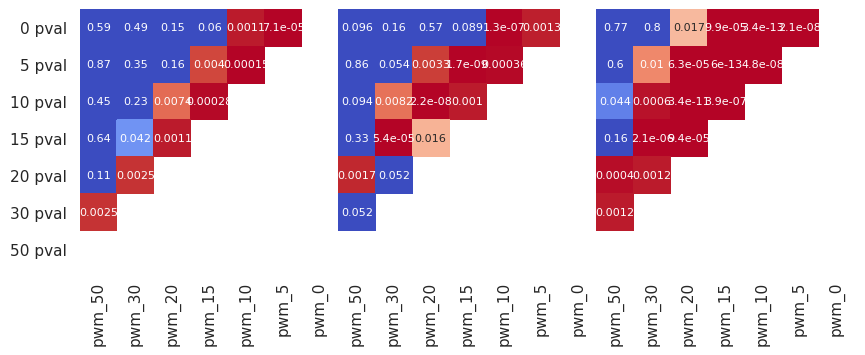

In [211]:
df_pval_pwm=ttest_plot_depth(allboxxx,'pwm')
df_pval_wg=ttest_plot_depth(allboxxx,'wg')
df_pval_me=ttest_plot_depth(allboxxx,'me')

allPval=pd.concat([df_pval_pwm,df_pval_wg,df_pval_me])

mask = np.zeros_like(allPval)
mask[np.triu_indices_from(allPval)] = True
cc=pd.DataFrame(np.flip(mask[0:7,0:7],axis=0))
mask=np.array(pd.concat([cc.T,cc.T,cc.T]))

sns.set(font_scale=1)

sns.set(font_scale=1)

with sns.axes_style("white"):

    f, ax = plt.subplots(figsize=(10, 7))
    
    ax = sns.heatmap(allPval.T,annot=True,mask=mask.T,cbar=False,
                     vmax=.05, square=True,cmap='coolwarm_r',
                    annot_kws={"size":8})
#     plt.xticks(rotation=30)

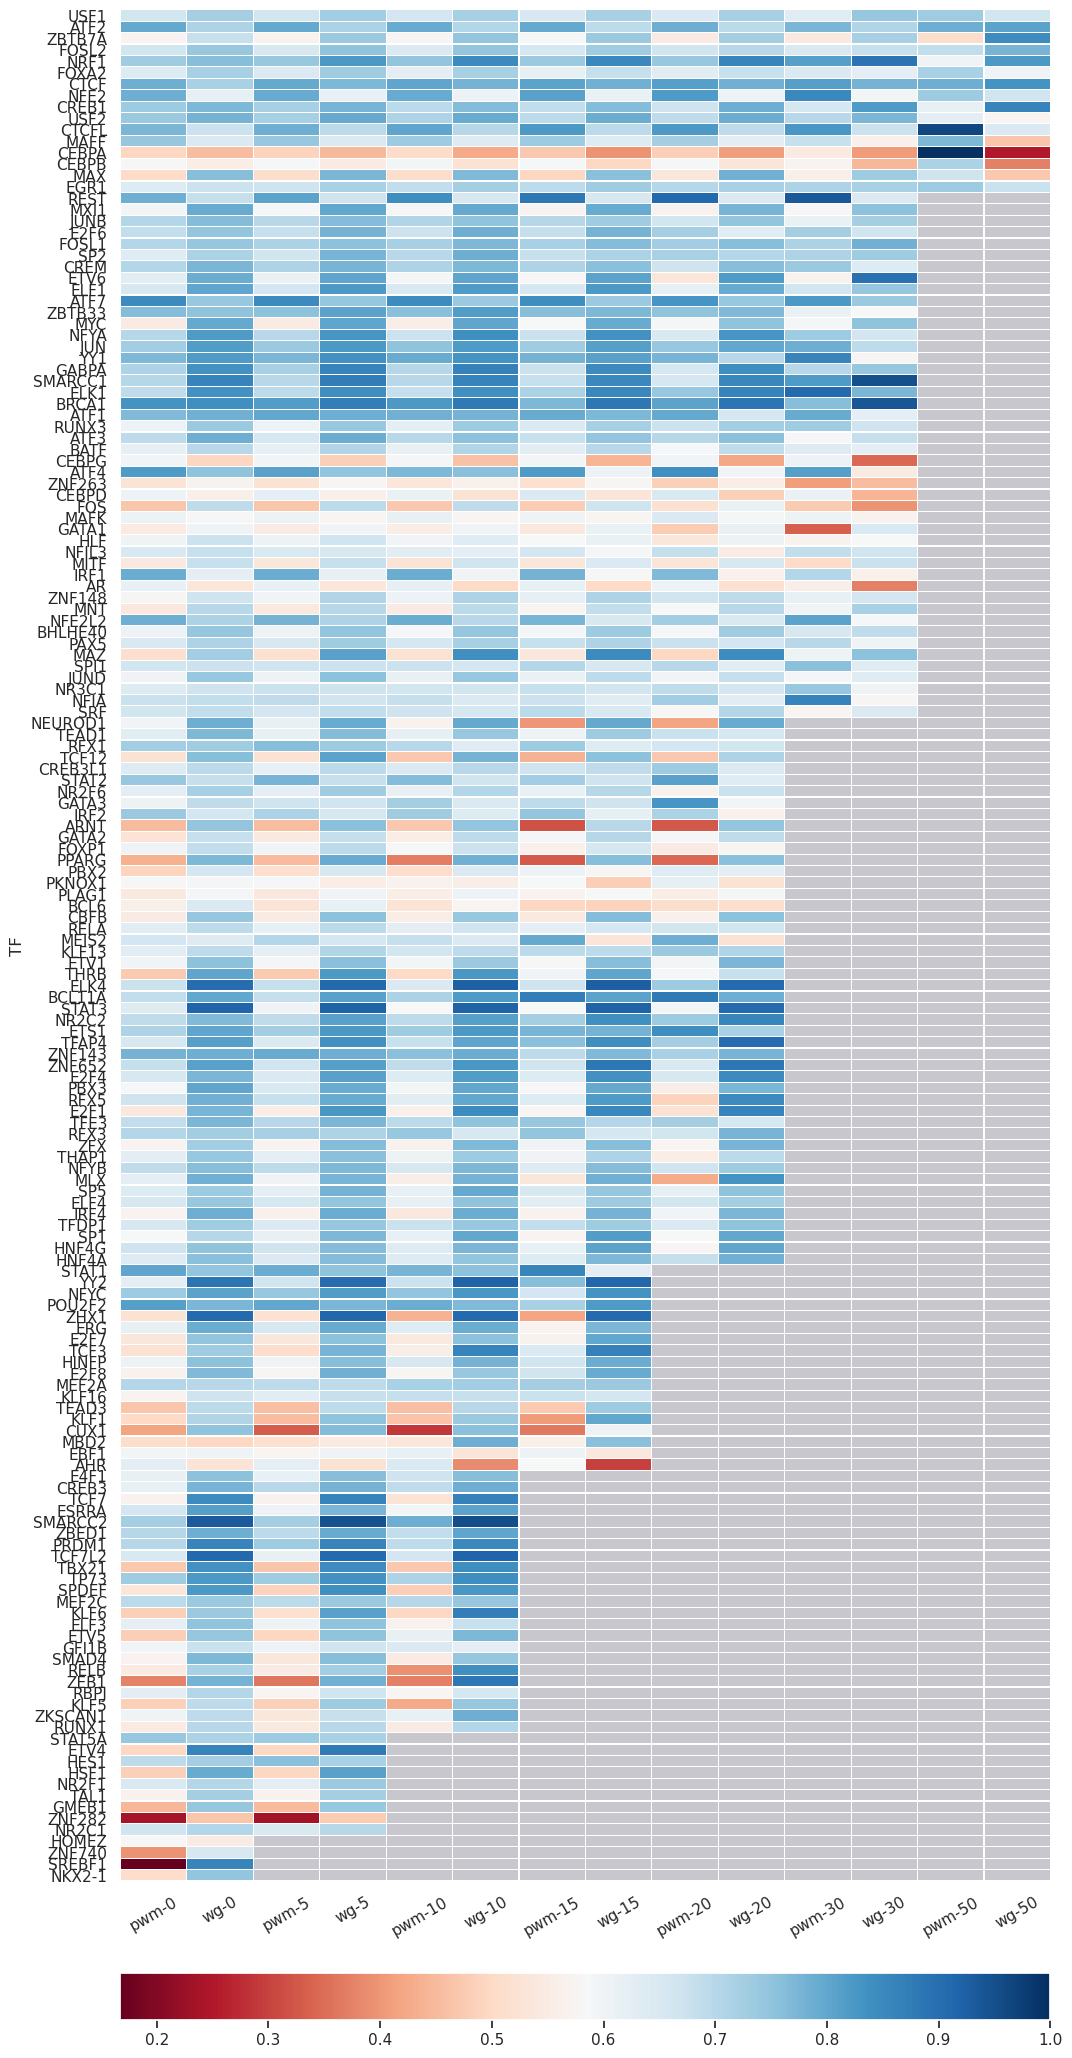

In [212]:
allbox=pd.DataFrame()
traces= glob.glob('data/MotifPipeline/compare/sthlm_motif_0_QC_beta_red/test/all/**/*.txt',recursive = True)
indices = [i for i, s in enumerate(traces) if 'sthlm_PRE_overall' in s]
measure='auroc'

for jac in (indices):
    trace=traces[jac]
    aurocs=pd.read_table(trace,sep=',',usecols=[1,2,3,4,5],names=['cell','TF','mo_auroc','wgbs_auroc','me_auroc'])#,'mo_aupr','wgbs_aupr','me_aupr','rand_mo_auroc','rand_wgbs_auroc','rand_me_auroc','rand_mo_aupr','rand_wgbs_aupr','rand_me_aupr','tr_wg_auroc','tr_me_auroc','tr_wg_aupr','tr_me_aupr'])
    aurocs=aurocs[aurocs.cell!='0']
    aurocs['depth']=(trace.split('/')[6])
    

    allbox=pd.concat([allbox,aurocs],axis=0)

allbox['depth']=allbox['depth'].replace('all',0)
allbox.depth=allbox.depth.astype(int)
allbox=allbox.sort_values(by='depth')

heat=allbox.pivot_table(index=['TF'], columns='depth')

heat['mean']=np.nanmean(heat,axis=1)
heat['count']=heat.isnull().sum(axis=1)

heat['weight']=heat['mean']*(heat['count'])
heat=heat.sort_values(by=['weight'],ascending=False)

del heat['count']
del heat['mean']
del heat['weight']
heat['sum']=heat.isnull().sum(axis=1)
heat=heat.sort_values(by=['sum'],ascending=True)
del heat['sum']
heat=pd.DataFrame(heat.to_records())


heat.columns=['TF','me-0','me-5','me-10','me-15','me-20','me-30','me-50',
             'pwm-0','pwm-5','pwm-10','pwm-15','pwm-20','pwm-30','pwm-50',
             'wg-0','wg-5','wg-10','wg-15','wg-20','wg-30','wg-50']

heat=heat[['TF','pwm-0','pwm-5','pwm-10','pwm-15','pwm-20','pwm-30','pwm-50',
#           'me-0','me-5','me-10','me-20','me-30','me-50',
             'wg-0','wg-5','wg-10','wg-15','wg-20','wg-30','wg-50']]


heat=heat[['TF','pwm-0','wg-0',
           'pwm-5','wg-5',
           'pwm-10', 'wg-10',
           'pwm-15', 'wg-15',
           'pwm-20','wg-20',
           'pwm-30','wg-30',
           'pwm-50','wg-50']]
heat55=heat
heat=heat.set_index('TF')

plt.figure(figsize=(12, 30))
rdgn = plt.get_cmap("RdBu")
rdgn.set_bad(color='black', alpha=0.15)

ax = sns.heatmap(heat,linewidth=.1,cmap=rdgn, cbar=False,mask=heat.isnull(),yticklabels=True)#cbar_ax=cbar_ax,cbar_kws={"orientation": "horizontal"})
mappable = ax.get_children()[0]
plt.colorbar(mappable, ax = [ax],orientation = 'horizontal',pad=.04) #.02 with 12x60, .03 for 12x40
plt.xticks(rotation=30)

plt.show


box=heat55

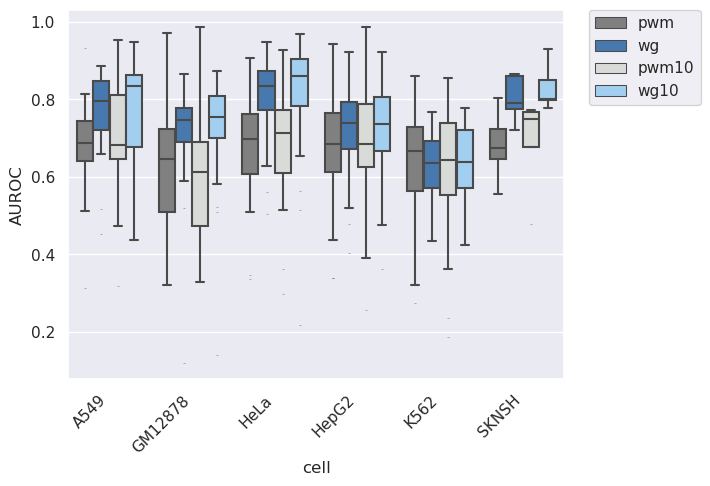

In [213]:

allbox = pd.DataFrame()

indir='../../d/tmp/redmo/data/MotifPipeline/cbus_motif_pipeline_delta0'
traces= glob.glob(indir+'/test/*_PRE_window_methyl_great10.txt',recursive = True)
method='AUROC'

for i,trace in enumerate(traces):

    TSS=(traces[i]).split('/')[9]
    TSS=(TSS).split('_')[0]

    meltbox=pd.read_csv(trace,sep=',',names=['cell','TF','pwm','wg','pwm10','wg10','fullsize','size10','yes'])

    allbox=pd.concat([allbox,meltbox],axis=0)
allbox00=pd.melt(allbox, id_vars=['cell','TF','fullsize','size10','yes'], value_vars=['pwm','wg','pwm10','wg10'])
allbox00['AUROC']=allbox00['value']
del allbox00['value']

allbox11=pd.melt(allbox, id_vars=['cell','TF','fullsize','size10','yes','pwm','pwm10'], value_vars=['wg','wg10'])
allbox11['AUROC']=allbox11['value']
del allbox11['value']



allbox00=allbox00.sort_values(['cell','variable'], axis=0)
aa=allbox00[allbox00['variable']=='pwm']
bb=allbox00[allbox00['variable']=='wg']
cc=allbox00[allbox00['variable']=='pwm10']
dd=allbox00[allbox00['variable']=='wg10']
allbox00=pd.concat([aa,bb,cc,dd])
plt.xticks(rotation=30)
g=sns.boxplot(x='cell',y=method.upper(), data=allbox00,hue='variable',fliersize = .1,palette=['grey',sns.xkcd_rgb["windows blue"],sns.xkcd_rgb["light grey"],sns.xkcd_rgb["light blue"]])

g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig(outdir+"S2B.png",dpi=300,bbox_inches = "tight")
plt.show()

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


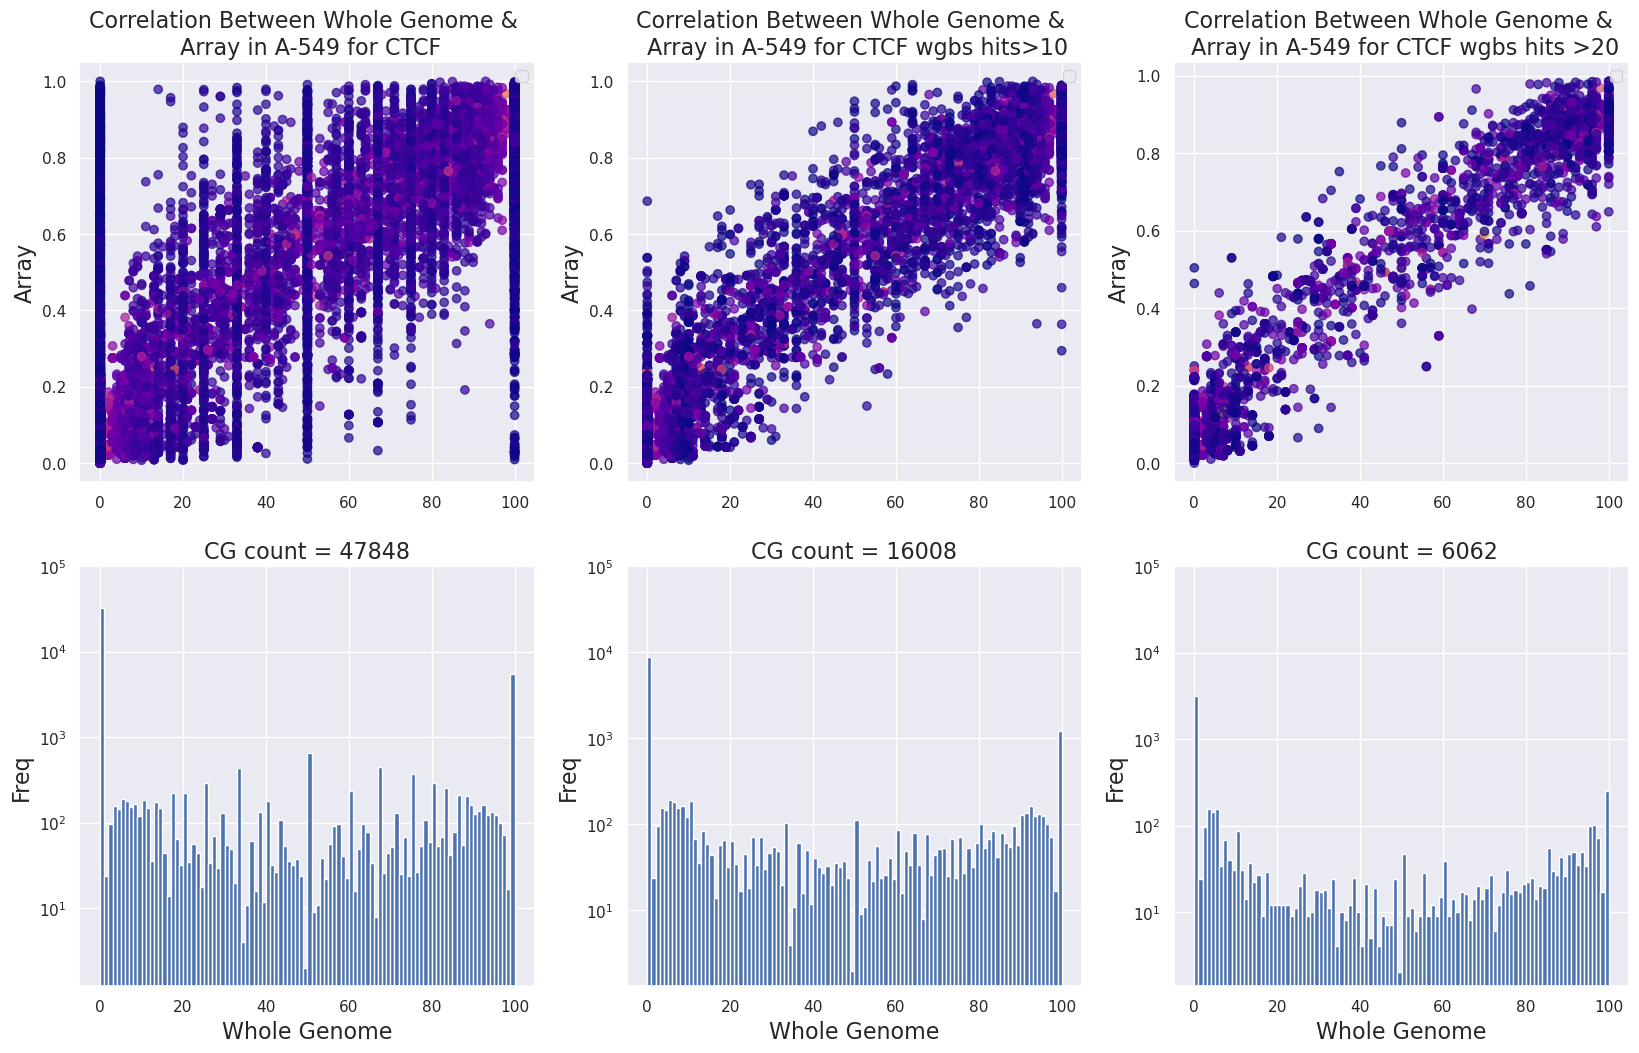

In [215]:

TF='CTCF'
chr='chr1'
cell='A-549'

tab=[]
traces= glob.glob(arxiv1+'data/MotifPipeline/sthlm_motif_0_QCbeta/*')

data=pd.read_csv(traces[zzzz],sep='\t',usecols=[0,1,2,3,8,9,10,15],names=["chr", "start", "end",'weight','hits1',"wgbs",'array',"ChIPTF"])
data=data[data['weight']!=data['wgbs']] ##subset of motif or entire motif flag
data=data[data['weight']!=data['array']]

df2=data
df2.hits1.astype('category')

f= plt.figure(figsize=(20, 12))
plt.subplot(2, 3, 1)
plt.scatter(df2.wgbs,df2.array,cmap='plasma',c=df2.hits1,alpha=.7) 
plt.legend(loc='best')
plt.title('Correlation Between Whole Genome & \n Array in '+cell+' for '+TF,fontsize=16)
plt.ylabel('Array',fontsize=16)

plt.subplot(2, 3, 2)
df2=df2[df2['hits1']>=10]
plt.scatter(df2.wgbs,df2.array,cmap='plasma',c=df2.hits1,alpha=.7) 
plt.legend(loc='best')
plt.title('Correlation Between Whole Genome & \n Array in '+cell+' for '+TF+' wgbs hits>10',fontsize=16)
plt.ylabel('Array',fontsize=16)

plt.subplot(2, 3, 3)
df2=df2[df2['hits1']>=20]
plt.scatter(df2.wgbs,df2.array,cmap='plasma',c=df2.hits1,alpha=.7) 
plt.legend(loc='best')
plt.title('Correlation Between Whole Genome & \n Array in '+cell+' for '+TF+' wgbs hits >20',fontsize=16)
plt.ylabel('Array',fontsize=16)

df2=data
df2.hits1.astype('category')

ax1=plt.subplot(2, 3, 4)
plt.hist(df2.wgbs,bins=100,log=True)#,df2.array,cmap='plasma',c=df2.hits,alpha=.7) 
plt.xlabel('Whole Genome',fontsize=16)
plt.ylabel('Freq',fontsize=16)
plt.title(len(df2),fontsize=16)
plt.title('CG count = '+str(len(df2)),fontsize=16)
ax1.set_ylim([0,100000])

ax2=plt.subplot(2, 3, 5)
df2=df2[df2['hits1']>=10]
plt.hist(df2.wgbs,bins=100,log=True)#,df2.array,cmap='plasma',c=df2.hits,alpha=.7) 
plt.xlabel('Whole Genome',fontsize=16)
plt.ylabel('Freq',fontsize=16)
plt.title('CG count = '+str(len(df2)),fontsize=16)

ax2.set_ylim([0,100000])

ax3=plt.subplot(2, 3, 6)
df2=df2[df2['hits1']>=20]
plt.hist(df2.wgbs,bins=100,log=True)#,df2.array,cmap='plasma',c=df2.hits,alpha=.7) 
plt.xlabel('Whole Genome',fontsize=16)
plt.ylabel('Freq',fontsize=16)
plt.title('CG count = '+str(len(df2)),fontsize=16)
ax3.set_ylim([0,100000])

# fig.show()
outdir='mili_benchmark/figures/'
plt.savefig(outdir+"S3.png")
